# Transformer 모델을 이용한 한-영 번역기

## 목차
1. 환경 설정  
2. EDA & 데이터 전처리  
3. 모델 설계  
4. 모델 학습  
5. 시각화 & 결과 해석  
6. Abulation Study & 회고  


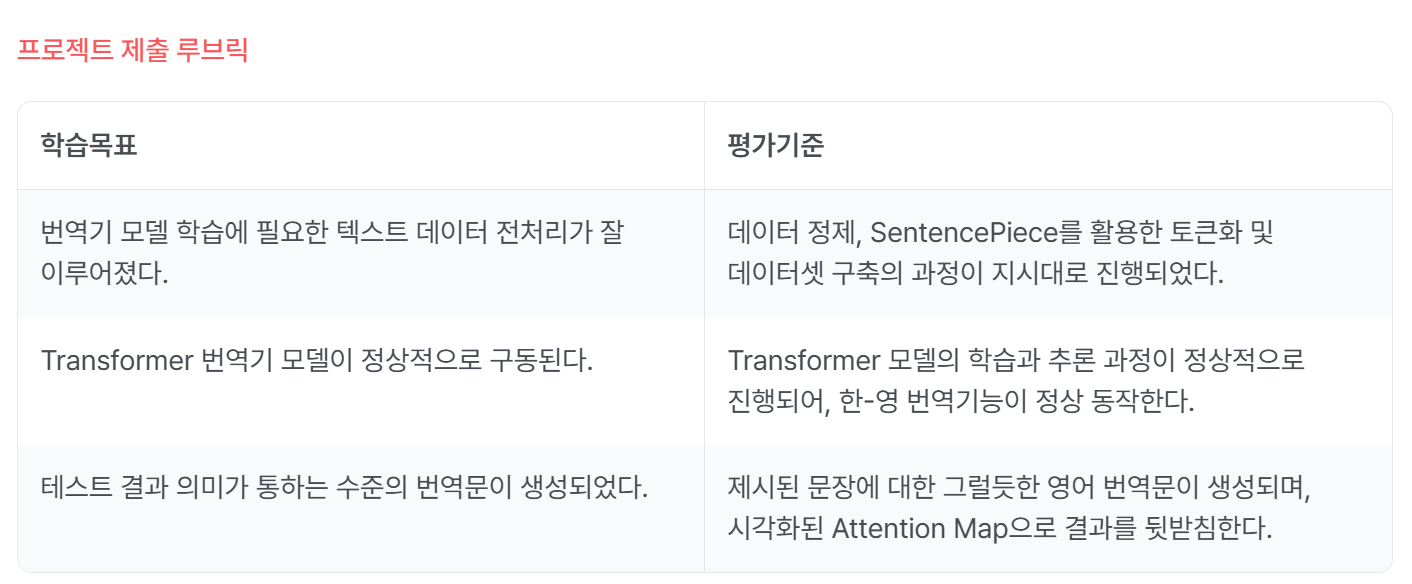  
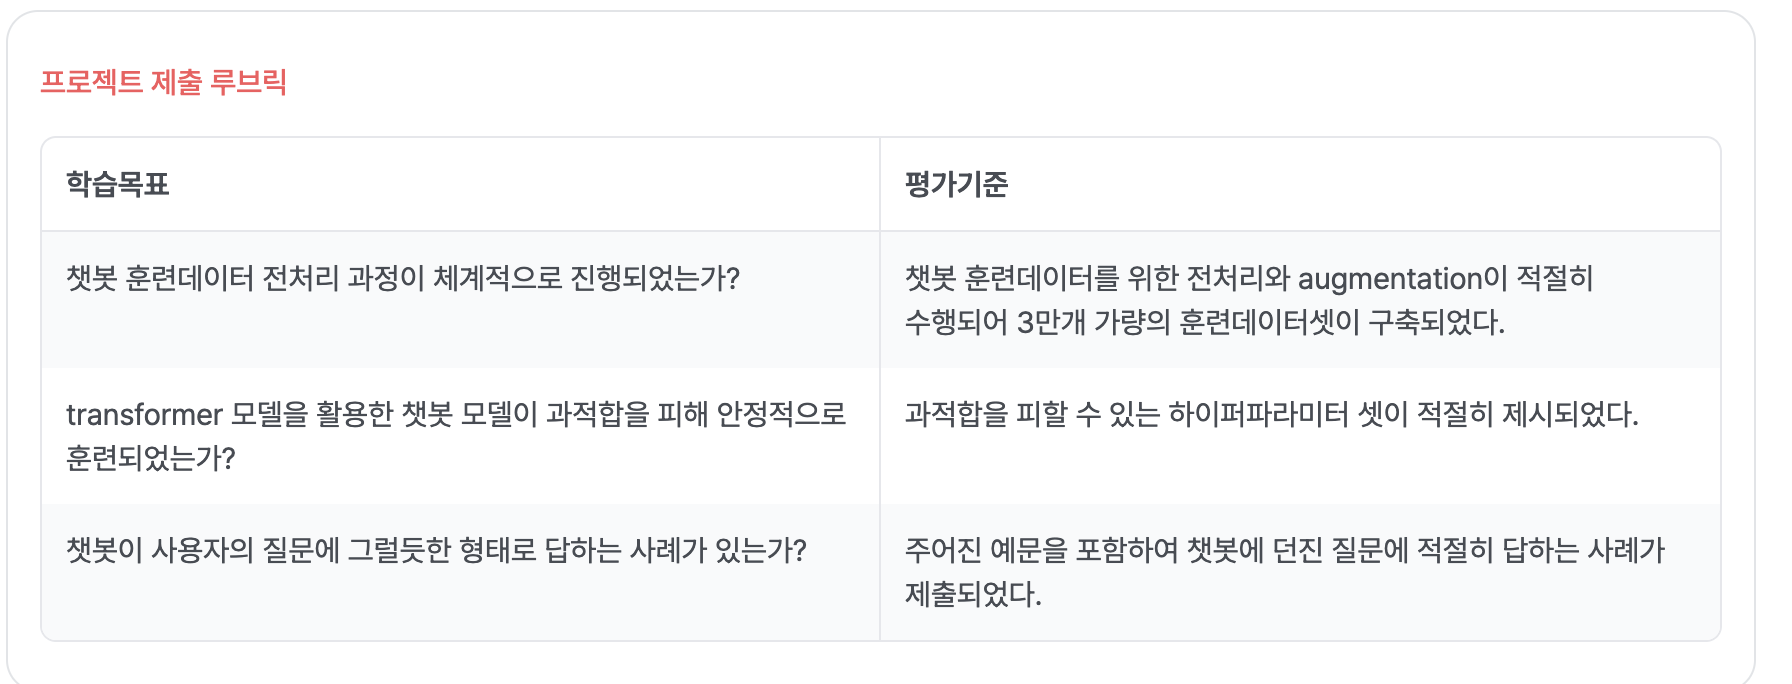

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/아이펠/AIFFEL_quest_rs/GoingDeeper/GD05"

/content/drive/MyDrive/Colab Notebooks/아이펠/AIFFEL_quest_rs/GoingDeeper/GD05


In [ ]:
%cd "/home/jovyan/work/AIFFEL_quest_rs/GoingDeeper/GD05"

/home/jovyan/work/AIFFEL_quest_rs/GoingDeeper/GD05


# Definition

## Section 1. 환경 설정

한글 폰트 설정

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and direc

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [ ]:
# 기본 라이브러리
import os
import re
import math
import time
import random
from typing import List, Tuple, Dict

# 데이터 처리
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install nltk
import nltk
import itertools

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# SentencePiece
!pip install sentencepiece
import sentencepiece as spm

# 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc

# 평가
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
!pip install evaluate bert_score rouge_score absl-py

# 진행바
from tqdm import tqdm

# 설정
!pip install easydict
from easydict import EasyDict

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 역번역
!pip install transformers
from transformers import MarianMTModel, MarianTokenizer

# gensim 다운로드
!pip install gensim
from gensim.models import KeyedVectors
import gensim.downloader as api
GENSIM_AVAILABLE = True

# 랜덤 시드 설정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.7 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=029fc632de13535bc734e0654758f3265476381170adb12988675db051ab9a8c
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score
Using device: cuda
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 40.8 MB/s eta 0:00:00


In [ ]:
import evaluate as hf_eval

## Section 2. 설정 (configuration)
모델 학습에 필요한 모든 설정을 정의
- 데이터 경로
- 배치 크기
- 에폭 수
- 모델 크기

In [ ]:
# data path
DATA_DIR = './data'
ENG_TRAIN_PATH = f'{DATA_DIR}/korean-english-park.train.en'
KOR_TRAIN_PATH = f'{DATA_DIR}/korean-english-park.train.ko'

# 저장 경로
MODEL_DIR = './models'
TOKENIZER_DIR = './tokenizers'
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TOKENIZER_DIR, exist_ok=True)

MODEL_SAVE_PATH = f'{MODEL_DIR}/transformer_eng_kor.pt'
ENG_TOKENIZER_PREFIX = f'{TOKENIZER_DIR}/sp_eng'
KOR_TOKENIZER_PREFIX = f'{TOKENIZER_DIR}/sp_kor'

# data configs
DATA_CONFIG = EasyDict({
    'train_ratio': 0.8,
    'val_ratio': 0.1,
    'test_ratio': 0.1,
    'alpha_sr': 0.1,
    'max_length': 70,     # 최대 시퀀스 길이
    'vocab_size_eng': 16000,
    'vocab_size_kor': 16000,
    'batch_size': 128,    # 배치 크기 (메모리에 맞게 조정)
    'num_workers': 4,     # DataLoader 워커 수
})

# Model config
MODEL_CONFIG = EasyDict({
    'emb_dim': 256,       # 임베딩 차원
    'ffn_dim': 1024,      # Feed-Forward 차원
    'num_heads': 8,       # 어텐션 헤드 수
    'encoder_layers': 6,  # 인코더 레이어 수
    'decoder_layers': 6,  # 디코더 레이어 수
    'dropout': 0.2,
    'attention_dropout': 0.2,
    'max_position_embeddings': 100,
})

# training config
TRAIN_CONFIG = EasyDict({
    'num_epochs': 70,
    'learning_rate': 1,
    'betas': (0.9, 0.98),
    'eps': 1e-9,
    'weight_decay': 0.01,
    'clip': 1.0,
    'label_smoothing': 0,
    'patience': 10,
    'min_delta': 1e-4,
    'amp': True
})

print("설정 완료!")
print(f"\n디바이스: {device}")
print(f"배치 크기: {DATA_CONFIG.batch_size}")
print(f"에폭 수: {TRAIN_CONFIG.num_epochs}")
print(f"모델 크기: {MODEL_CONFIG.emb_dim}")

설정 완료!

디바이스: cuda
배치 크기: 128
에폭 수: 70
모델 크기: 256


## Section 3. 전처리 함수
- text 정제
- data load
- back-translation

In [ ]:
def preprocess_sentence(sentence: str, lang: str = 'kor') -> str:
    """
    문장을 전처리합니다.

    Args:
        sentence: 전처리할 문장
        lang: 언어 타입 ('eng' 또는 'kor')

    Returns:
        전처리된 문장
    """
    sentence = sentence.lower().strip()

    if lang == 'eng':
        sentence = re.sub(r"[^a-zA-Z0-9?.!,']+", " ", sentence)
    else:
        sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9?.!,]+", " ", sentence)

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 문장부호 앞뒤로 공백 추가
    sentence = re.sub(r'\s+', ' ', sentence) # 연속 공백을 하나의 공백으로 교체
    sentence = sentence.strip()

    return sentence


def load_data(kor_path: str, eng_path: str):
    """
    한국어-영어 병렬 말뭉치를 로드하고 전처리합니다.
    """
    print("=" * 60)
    print("데이터 로드 및 전처리 시작...")

    with open(kor_path, 'r', encoding='utf-8') as f:
        kor_lines = f.readlines()

    with open(eng_path, 'r', encoding='utf-8') as f:
        eng_lines = f.readlines()

    questions = []
    answers = []
    cleaned_pairs = set()

    for kor, eng in zip(kor_lines, eng_lines):
        clean_kor = preprocess_sentence(kor, lang='kor')
        clean_eng = preprocess_sentence(eng, lang='eng')

        if clean_kor and clean_eng and (clean_kor, clean_eng) not in cleaned_pairs:
            cleaned_pairs.add((clean_kor, clean_eng))
            questions.append(clean_kor)
            answers.append(clean_eng)

    print(f"전체 유효 데이터 쌍: {len(questions):,}")
    print("데이터 로드 완료!")
    print("=" * 60)

    return questions, answers


def back_translation_augment(train_q, train_a, sample_size=3000, batch_size=32):
    """
    Back Translation(역번역)을 사용하여 데이터를 증강합니다.

    Flow: 영어(Target) -> [번역 모델] -> 한국어(New Source)
    결과: (기계 번역된 한국어, 원본 영어) 쌍을 추가

    Args:
        train_q: 원본 한국어 리스트
        train_a: 원본 영어 리스트
        sample_size: 증강할 샘플 개수 (원본 데이터 크기가 충분히 크기 때문에 기본 3000으로 설정함)
        batch_size: 한 번에 번역할 배치 크기 (GPU 메모리에 따라 조절)

    Returns:
        증강된 train_q, train_a 리스트
    """
    print("=" * 60)
    print(f"역번역(Back Translation) 데이터 증강 시작")
    print(f"  - 목표 샘플 수: {sample_size}개")
    print(f"  - 사용할 모델: Helsinki-NLP/opus-mt-tc-big-en-ko (Eng -> Kor)")
    print("=" * 60)

    # 1. 모델 및 토크나이저 로드
    model_name = "Helsinki-NLP/opus-mt-tc-big-en-ko"
    try:
        tokenizer = MarianTokenizer.from_pretrained(model_name)
        model = MarianMTModel.from_pretrained(model_name).to(device)
        print("  모델 로드 완료!")
    except Exception as e:
        print(f"모델 로드 실패: {e}")
        return train_q, train_a

    # 2. 랜덤 샘플링 (인덱스 추출)
    total_len = len(train_a)
    if sample_size > total_len:
        print("Warning: 요청한 샘플 수가 전체 데이터보다 많습니다. 전체 데이터를 사용합니다.")
        sample_indices = range(total_len)
    else:
        sample_indices = random.sample(range(total_len), sample_size)

    # 선택된 영어 문장 가져오기
    target_sentences = [train_a[i] for i in sample_indices]

    # 3. 배치 단위로 번역 수행 (영어 -> 한국어)
    augmented_kor = []

    print("  번역 진행 중...")
    model.eval()

    with torch.no_grad():
        for i in tqdm(range(0, len(target_sentences), batch_size), desc="  Back-Translating"):
            batch_texts = target_sentences[i : i + batch_size]

            # 토크나이징
            inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

            # 번역 생성
            translated = model.generate(**inputs)

            # 디코딩
            decoded = tokenizer.batch_decode(translated, skip_special_tokens=True)
            augmented_kor.extend(decoded)

    # 4. 데이터 합치기
    # 기존 데이터 복사
    final_q = list(train_q)
    final_a = list(train_a)

    # 증강 데이터 추가 (New Kor, Original Eng)
    final_q.extend(augmented_kor)
    final_a.extend(target_sentences)

    print("\n" + "=" * 60)
    print("역번역 증강 완료!")
    print(f"  기존 데이터: {len(train_q):,}")
    print(f"  추가된 데이터: {len(augmented_kor):,}")
    print(f"  최종 데이터: {len(final_q):,}")
    print("=" * 60)

    # 메모리 정리
    del model
    del tokenizer
    torch.cuda.empty_cache()

    return final_q, final_a

## Section 4. 토크나이저
SentencePiece 토크나이저 정의

In [ ]:
def train_sentencepiece(data: List[str], model_prefix: str, vocab_size: int = 8000):
    """
    SentencePiece 모델을 학습합니다.
    """
    print("=" * 60)
    print(f"SentencePiece 학습: {model_prefix} (Vocab: {vocab_size})")

    corpus_path = f'{model_prefix}_corpus.txt'
    with open(corpus_path, 'w', encoding='utf-8') as f:
        for line in data:
            f.write(f'{line}\n')

    train_args = (
        f'--input={corpus_path} '
        f'--model_prefix={model_prefix} '
        f'--vocab_size={vocab_size} '
        f'--model_type=unigram '
        f'--pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 '
        f'--character_coverage=1.0'
    )

    spm.SentencePieceTrainer.Train(train_args)

    if os.path.exists(corpus_path):
        os.remove(corpus_path)

    print(f"완료: {model_prefix}.model")
    print("=" * 60)
    return f"{model_prefix}.model"


class SentencePieceVocab:
    """
    SentencePiece 기반 어휘 사전 클래스
    """

    def __init__(self, model_path: str):
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(model_path)

        self.PAD_ID = 0
        self.UNK_ID = 1
        self.BOS_ID = 2
        self.EOS_ID = 3

        self.stoi = {'<pad>': 0, '<unk>': 1, '<s>': 2, '</s>': 3}
        self.itos = [self.sp.IdToPiece(i) for i in range(self.sp.GetPieceSize())]

    def encode(self, text: str) -> List[int]:
        return self.sp.EncodeAsIds(text)

    def decode(self, ids: List[int]) -> str:
        filtered_ids = [i for i in ids if i not in [self.PAD_ID, self.BOS_ID, self.EOS_ID]]
        return self.sp.DecodeIds(filtered_ids)

    def __len__(self) -> int:
        return self.sp.GetPieceSize()


print("토크나이저 클래스 정의 완료!")

토크나이저 클래스 정의 완료!


## Section 5. Dataset & DataLoader
번역 작업을 위한 Dataset과 DataLoader를 정의

In [ ]:
class TranslationDataset(Dataset):
    """
    번역 작업을 위한 PyTorch Dataset
    """

    def __init__(self, src_list, trg_list, vocab_src, vocab_trg, max_length=60):
        self.src_list = src_list
        self.trg_list = trg_list
        self.vocab_src = vocab_src
        self.vocab_trg = vocab_trg
        self.max_length = max_length

    def __len__(self):
        return len(self.src_list)

    def __getitem__(self, idx):
        src_text = self.src_list[idx]
        trg_text = self.trg_list[idx]

        src_encoded = [self.vocab_src.BOS_ID] + self.vocab_src.encode(src_text) + [self.vocab_src.EOS_ID]

        trg_encoded = [self.vocab_trg.BOS_ID] + self.vocab_trg.encode(trg_text) + [self.vocab_trg.EOS_ID]

        src_encoded = src_encoded[:self.max_length]
        trg_encoded = trg_encoded[:self.max_length]

        return {
            'SRC': torch.tensor(src_encoded, dtype=torch.long),
            'TRG': torch.tensor(trg_encoded, dtype=torch.long),
            'SRC_TEXT': src_text,
            'TRG_TEXT': trg_text
        }


def collate_fn(batch, pad_idx=0):
    """
    배치 내 샘플들을 동일한 길이로 패딩합니다.
    """
    src_batch = [item['SRC'] for item in batch]
    trg_batch = [item['TRG'] for item in batch]
    src_text = [item['SRC_TEXT'] for item in batch]
    trg_text = [item['TRG_TEXT'] for item in batch]

    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=pad_idx)
    trg_padded = pad_sequence(trg_batch, batch_first=True, padding_value=pad_idx)

    return {
        'SRC': src_padded,
        'TRG': trg_padded,
        'SRC_TEXT': src_text,
        'TRG_TEXT': trg_text
    }


print("Dataset 및 DataLoader 함수 정의 완료!")

Dataset 및 DataLoader 함수 정의 완료!


## Section 6. 모델
Transformer 모델과 하위 모듈 정의  
- Multi-Head Attention
- Feed-Forward
- Sinusoidal Positional Embedding
- Encoder Layer
- Encoder
- Decoder Layer
- Decoder
- Transformer

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    멀티 헤드 어텐션 (Multi-Head Attention)
    """

    def __init__(self, emb_dim, num_heads, dropout=0.0, bias=False,
                 encoder_decoder_attention=False, causal=False):
        super().__init__()

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = emb_dim // num_heads

        # emb_dim(d_model)은 num_heads로 나누어떨어져야 함
        assert self.head_dim * num_heads == self.emb_dim

        self.encoder_decoder_attention = encoder_decoder_attention
        self.causal = causal

        self.q_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.k_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.v_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.out_proj = nn.Linear(emb_dim, emb_dim, bias=bias)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_heads, self.head_dim)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, query, key, attention_mask=None):
        q = self.q_proj(query)

        if self.encoder_decoder_attention:
            k = self.k_proj(key)
            v = self.v_proj(key)
        else:
            k = self.k_proj(query)
            v = self.v_proj(query)

        q = self.transpose_for_scores(q)
        k = self.transpose_for_scores(k)
        v = self.transpose_for_scores(v)

        attn_weights = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(self.head_dim)

        if attention_mask is not None:
            if self.causal:
                attn_weights = attn_weights.masked_fill(
                    attention_mask.unsqueeze(0).unsqueeze(1), float("-inf")
                )
            else:
                attn_weights = attn_weights.masked_fill(
                    attention_mask.unsqueeze(1).unsqueeze(2), float("-inf")
                )

        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_probs = F.dropout(attn_weights, p=self.dropout, training=self.training)
        attn_output = torch.matmul(attn_probs, v)

        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()
        concat_shape = attn_output.size()[:-2] + (self.emb_dim,)
        attn_output = attn_output.view(*concat_shape)
        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights


class PositionWiseFeedForward(nn.Module):
    """
    위치별 피드포워드 네트워크
    """

    def __init__(self, emb_dim, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(emb_dim, d_ff)
        self.w_2 = nn.Linear(d_ff, emb_dim)
        self.dropout = dropout
        self.activation = nn.ReLU()

    def forward(self, x):
        # residual = x -> 아래 EncoderLayer에서 잔차 연결을 하므로 여기선 제외한다.
        x = self.activation(self.w_1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.w_2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x #+ residual


class SinusoidalPositionalEmbedding(nn.Embedding):
    """
    사인/코사인 위치 임베딩
    """

    def __init__(self, num_positions, embedding_dim, padding_idx=None):
        super().__init__(num_positions, embedding_dim)
        self._init_weight(self.weight)

    @staticmethod
    def _init_weight(out):
        n_pos, embed_dim = out.shape
        position_enc = torch.zeros(n_pos, embed_dim)

        for pos in range(n_pos):
            for i in range(0, embed_dim, 2):
                position_enc[pos, i] = math.sin(pos / (10000 ** (i / embed_dim)))
                if i + 1 < embed_dim:
                    position_enc[pos, i + 1] = math.cos(pos / (10000 ** ((i + 1) / embed_dim)))

        out.data.copy_(position_enc)
        out.requires_grad = False

    @torch.no_grad() # 데코레이터(@) 방식은 함수 전체에 적용되게 한다.
    def forward(self, input_ids):
        bsz, seq_len = input_ids.shape[:2]
        positions = torch.arange(seq_len, dtype=torch.long, device=self.weight.device)
        return super().forward(positions)

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attn = MultiHeadAttention(config.emb_dim, config.num_heads, config.attention_dropout)
        self.ffn = PositionWiseFeedForward(config.emb_dim, config.ffn_dim, config.dropout)
        self.norm1 = nn.LayerNorm(config.emb_dim)
        self.norm2 = nn.LayerNorm(config.emb_dim)
        self.dropout = config.dropout

    def forward(self, x, attention_mask=None):
        norm_x = self.norm1(x)
        attn_output, attn_weights = self.self_attn(norm_x, norm_x, attention_mask)
        x = x + F.dropout(attn_output, p=self.dropout, training=self.training) # 여기서 잔차 연결까지 포함

        norm_x = self.norm2(x)
        ffn_output = self.ffn(norm_x)
        x = x + F.dropout(ffn_output, p=self.dropout, training=self.training)

        return x, attn_weights


class Encoder(nn.Module):
    def __init__(self, config, embed_tokens):
        super().__init__()
        self.config = config
        self.padding_idx = embed_tokens.padding_idx
        self.embed_tokens = embed_tokens
        self.embed_positions = SinusoidalPositionalEmbedding(
            config.max_position_embeddings, config.emb_dim, self.padding_idx
        )
        self.layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.encoder_layers)])
        self.dropout = nn.Dropout(config.dropout)
        self.final_norm = nn.LayerNorm(config.emb_dim)

    def forward(self, input_ids, attention_mask=None):
        inputs_embeds = self.embed_tokens(input_ids)
        inputs_embeds = inputs_embeds * math.sqrt(self.config.emb_dim) # 스케일링
        embed_pos = self.embed_positions(input_ids)
        x = self.dropout(inputs_embeds + embed_pos)

        attention_scores = []
        for layer in self.layers:
            x, attn = layer(x, attention_mask)
            attention_scores.append(attn)

        x = self.final_norm(x)
        return x, attention_scores


class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attn = MultiHeadAttention(config.emb_dim, config.num_heads, config.attention_dropout, causal=True)
        self.cross_attn = MultiHeadAttention(config.emb_dim, config.num_heads, config.attention_dropout, encoder_decoder_attention=True)
        self.ffn = PositionWiseFeedForward(config.emb_dim, config.ffn_dim, config.dropout)
        self.norm1 = nn.LayerNorm(config.emb_dim)
        self.norm2 = nn.LayerNorm(config.emb_dim)
        self.norm3 = nn.LayerNorm(config.emb_dim)
        self.dropout = config.dropout

    def forward(self, x, encoder_output, encoder_attention_mask=None, decoder_causal_mask=None):
        norm_x = self.norm1(x)
        self_attn_output, self_attn_weights = self.self_attn(norm_x, norm_x, decoder_causal_mask)
        x = x + F.dropout(self_attn_output, p=self.dropout, training=self.training)

        norm_x = self.norm2(x)
        cross_attn_output, cross_attn_weights = self.cross_attn(norm_x, encoder_output, encoder_attention_mask)
        x = x + F.dropout(cross_attn_output, p=self.dropout, training=self.training)

        norm_x = self.norm3(x)
        ffn_output = self.ffn(norm_x)
        x = x + F.dropout(ffn_output, p=self.dropout, training=self.training)

        return x, (self_attn_weights, cross_attn_weights)


class Decoder(nn.Module):
    def __init__(self, config, embed_tokens):
        super().__init__()
        self.config = config
        self.padding_idx = embed_tokens.padding_idx
        self.embed_tokens = embed_tokens
        self.embed_positions = SinusoidalPositionalEmbedding(
            config.max_position_embeddings, config.emb_dim, self.padding_idx
        )
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.decoder_layers)])
        self.dropout = nn.Dropout(config.dropout)
        self.final_norm = nn.LayerNorm(config.emb_dim)

    def forward(self, input_ids, encoder_output, encoder_attention_mask=None, decoder_causal_mask=None):
        inputs_embeds = self.embed_tokens(input_ids)
        inputs_embeds = inputs_embeds * math.sqrt(self.config.emb_dim) # 스케일링
        embed_pos = self.embed_positions(input_ids)
        x = self.dropout(inputs_embeds + embed_pos)

        attention_scores = []
        for layer in self.layers:
            x, attn = layer(x, encoder_output, encoder_attention_mask, decoder_causal_mask)
            attention_scores.append(attn)

        x = self.final_norm(x)
        return x, attention_scores


class Transformer(nn.Module):
    """
    Transformer 모델
    """

    def __init__(self, vocab_src, vocab_trg, config):
        super().__init__()
        self.vocab_src = vocab_src
        self.vocab_trg = vocab_trg
        self.config = config

        self.enc_embedding = nn.Embedding(len(vocab_src), config.emb_dim, padding_idx=vocab_src.PAD_ID)
        self.dec_embedding = nn.Embedding(len(vocab_trg), config.emb_dim, padding_idx=vocab_trg.PAD_ID)

        self.encoder = Encoder(config, self.enc_embedding)
        self.decoder = Decoder(config, self.dec_embedding)
        self.prediction_head = nn.Linear(config.emb_dim, len(vocab_trg))

        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def generate_mask(self, src, trg):
        enc_attention_mask = (src == self.vocab_src.PAD_ID)
        tgt_len = trg.size(1)
        dec_causal_mask = torch.triu(
            torch.ones(tgt_len, tgt_len, dtype=torch.bool, device=trg.device), diagonal=1
        )
        return enc_attention_mask, dec_causal_mask

    def forward(self, src, trg):
        enc_attention_mask, dec_causal_mask = self.generate_mask(src, trg)
        encoder_output, encoder_attn = self.encoder(src, enc_attention_mask)
        decoder_output, decoder_attn = self.decoder(trg, encoder_output, enc_attention_mask, dec_causal_mask)
        logits = self.prediction_head(decoder_output)
        return logits, encoder_attn, decoder_attn

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

## Section 7. 학습 및 평가 utility
- 학습률 스케줄러
- Labal Smoothing 적용 CELoss
- train
- evaluate
- translate

In [ ]:
# Noam Scheduler 정의 (LambdaLR 활용)
def get_noam_scheduler(optimizer, d_model, warmup_steps=4000):
    def lr_lambda(step):
        step += 1  # step은 0부터 시작하므로 1을 더해줌
        arg1 = step ** -0.5
        arg2 = step * (warmup_steps ** -1.5)

        # 논문의 수식: d_model^(-0.5) * min(step^(-0.5), step * warmup_steps^(-1.5))
        return (d_model ** -0.5) * min(arg1, arg2)

    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# class LabelSmoothingLoss(nn.Module):
#     """
#     Label Smoothing을 적용한 Cross Entropy Loss
#     """

#     def __init__(self, classes, smoothing=0.1, dim=-1, ignore_index=None):
#         super().__init__()
#         self.confidence = 1.0 - smoothing
#         self.smoothing = smoothing
#         self.cls = classes
#         self.dim = dim
#         self.ignore_index = ignore_index

#     def forward(self, pred, target):
#         pred = pred.log_softmax(dim=self.dim)

#         with torch.no_grad():
#             true_dist = torch.zeros_like(pred)
#             true_dist.fill_(self.smoothing / (self.cls - 2))
#             true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)

#             if self.ignore_index is not None:
#                 true_dist[:, self.ignore_index] = 0
#                 mask = torch.nonzero(target.data == self.ignore_index)
#                 if mask.dim() > 0:
#                     true_dist.index_fill_(0, mask.squeeze(), 0.0)

#         return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))


# def train_epoch(model, iterator, optimizer, criterion, clip, device):
#     """
#     한 에폭 동안 모델을 학습합니다.
#     """
#     model.train()
#     epoch_loss = 0

#     # progress_bar = tqdm(iterator, desc="  Training", leave=False)
#     batches = iterator

#     for batch in batches :
#         src = batch['SRC'].to(device)
#         trg = batch['TRG'].to(device)

#         optimizer.zero_grad()
#         output, _, _ = model(src, trg[:, :-1])

#         output_dim = output.shape[-1]
#         output = output.contiguous().view(-1, output_dim)
#         trg = trg[:, 1:].contiguous().view(-1)

#         loss = criterion(output, trg)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
#         optimizer.step()

#         epoch_loss += loss.item()
#         # progress_bar.set_postfix(loss=f"{loss.item():.3f}")

#     return epoch_loss / len(iterator)

import torch.cuda.amp as amp

def train_epoch(model, iterator, optimizer, criterion, clip, device, scaler, scheduler):
    """
    Mixed Precision(AMP)과 Scheduler가 포함된 학습 함수
    """
    model.train()
    epoch_loss = 0

    # Mixed Precision 사용 여부 확인
    use_amp = TRAIN_CONFIG.amp

    for batch in iterator:
        src = batch['SRC'].to(device)
        trg = batch['TRG'].to(device)

        optimizer.zero_grad()

        # 1. Autocast 적용 (Forward Pass & Loss Calculation)
        #    연산을 FP16(반정밀도)으로 수행하여 메모리 절약 및 속도 향상
        with amp.autocast(enabled=use_amp):
            output, _, _ = model(src, trg[:, :-1])

            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, trg)

        # 2. Backward Pass & Optimizer Step (Scaler 사용)
        if use_amp:
            # Loss 스케일링 후 역전파 (Underflow 방지)
            scaler.scale(loss).backward()

            # Gradient Clipping을 위해 스케일링 된 것을 다시 풂 (Unscale)
            scaler.unscale_(optimizer)

            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            # 파라미터 업데이트 (스케일링 된 상태에서 step 수행 여부 결정)
            scaler.step(optimizer)

            # Scaler 업데이트 (다음 step을 위해 스케일 팩터 조정)
            scaler.update()
        else:
            # 기존 방식 (MPS, CPU 등 AMP 미지원 시)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        # 3. Scheduler Step (매 배치마다 학습률 조정)
        #    Transformer는 배치 단위로 LR을 업데이트하는 것이 일반적입니다.
        scheduler.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate_step(model, iterator, criterion, device):
    """
    모델을 평가
    """
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for batch in iterator:
            src = batch['SRC'].to(device)
            trg = batch['TRG'].to(device)

            output, _, _ = model(src, trg[:, :-1])

            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def calculate_comprehensive_metrics(model, iterator, tokenizer_src, tokenizer_trg, device):
    """
    BLEU, METEOR, ROUGE-L, BERTScore를 한 번에 계산
    """
    model.eval()

    # 1. 평가 도구 로드
    metric_bleu = hf_eval.load("bleu")
    metric_meteor = hf_eval.load("meteor")
    metric_rouge = hf_eval.load("rouge")
    metric_bert = hf_eval.load("bertscore")

    preds = []
    refs = []

    print("전체 테스트 데이터에 대해 번역 생성 중...")

    # 2. 전체 데이터에 대해 추론 (Batch 단위)
    with torch.no_grad():
        for batch in tqdm(iterator, desc="Generating"):
            src = batch['SRC'].to(device)
            trg = batch['TRG'].to(device)

            # --- 번역 수행 (Greedy Decoding) ---
            # 주의: 실제 성능 측정 시에는 Beam Search를 쓰면 더 좋지만,
            # 속도를 위해 기존 로직(Greedy)을 그대로 활용하거나 translate_sentence 함수 로직 사용

            # 배치 처리를 위해 간단한 루프 (혹은 기존 translate_sentence 활용)
            # 여기서는 편의상 배치 내 문장을 하나씩 디코딩합니다.
            batch_size = src.shape[0]

            for i in range(batch_size):
                # 소스 문장 (ID -> Text)
                src_ids = src[i].tolist()
                src_text = tokenizer_src.decode(src_ids) # Special token 제거됨

                # 정답 문장 (ID -> Text)
                trg_ids = trg[i].tolist()
                trg_text = tokenizer_trg.decode(trg_ids) # Special token 제거됨

                # 예측 문장 생성 (기존에 정의된 translate_sentence 활용 권장)
                # 여기서는 함수 호출 비용을 줄이기 위해 간단히 로직 인용
                # (실제로는 translate_sentence 함수를 호출하여 리스트로 받으세요)
                pred_tokens, _ = translate_sentence(src_text, model, tokenizer_src, tokenizer_trg, device)

                # 토큰 리스트 -> 문장열 결합
                pred_text = "".join(pred_tokens).replace(" ", " ").strip()

                preds.append(pred_text)
                refs.append(trg_text) # evaluate 라이브러리는 리스트 형태 [[ref], [ref]] 가 아니라 [ref, ref] 형태 요구 (BLEU 제외)

    print("\n지표 계산 중... (BERTScore는 시간이 좀 걸립니다)")

    # 3. 지표 계산

    # BLEU (references는 리스트의 리스트여야 함)
    results_bleu = metric_bleu.compute(predictions=preds, references=[[r] for r in refs])

    # METEOR
    results_meteor = metric_meteor.compute(predictions=preds, references=refs)

    # ROUGE
    results_rouge = metric_rouge.compute(predictions=preds, references=refs)

    # BERTScore (English 모델 사용)
    results_bert = metric_bert.compute(predictions=preds, references=refs, lang="en", verbose=True)

    # 4. 결과 출력
    scores = {
        "BLEU": results_bleu['bleu'],
        "METEOR": results_meteor['meteor'],
        "ROUGE-L": results_rouge['rougeL'],
        "BERTScore": sum(results_bert['f1']) / len(results_bert['f1']) # F1 평균
    }

    print("=" * 50)
    print(f"최종 평가 결과:")
    print(f"  BLEU:      {scores['BLEU']:.4f}")
    print(f"  METEOR:    {scores['METEOR']:.4f}")
    print(f"  ROUGE-L:   {scores['ROUGE-L']:.4f}")
    print(f"  BERTScore: {scores['BERTScore']:.4f}")
    print("=" * 50)

    return scores


def translate_sentence(sentence, model, vocab_src, vocab_trg, device, max_len=70):
    """
    하나의 문장을 번역
    """
    model.eval()

    if isinstance(sentence, str):
        tokens = [vocab_src.BOS_ID] + vocab_src.encode(sentence) + [vocab_src.EOS_ID]
    else:
        tokens = [vocab_src.BOS_ID] + vocab_src.encode(sentence) + [vocab_src.EOS_ID]

    src_tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)
    src_mask = (src_tensor == vocab_src.PAD_ID)

    with torch.no_grad():
        encoder_output, _ = model.encoder(src_tensor, src_mask)
        trg_indexes = [vocab_trg.BOS_ID]

        for i in range(max_len):
            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
            tgt_len = trg_tensor.size(1)
            dec_causal_mask = torch.triu(
                torch.ones(tgt_len, tgt_len, dtype=torch.bool, device=device), diagonal=1
            )

            decoder_output, decoder_attn = model.decoder(
                trg_tensor, encoder_output, src_mask, dec_causal_mask
            )

            pred_token = decoder_output.argmax(2)[:, -1].item()
            trg_indexes.append(pred_token)

            if pred_token == vocab_trg.EOS_ID:
                break

    translated_tokens = [vocab_trg.itos[i] for i in trg_indexes]
    attention = decoder_attn[-1][1].squeeze(0).cpu().detach().numpy()

    return translated_tokens[1:], attention

## Section 8. Attention Map
어텐션을 시각화하는 display_attention 함수 정의

In [ ]:
def display_attention(src_tokens, trg_tokens, attention, n_heads=8):
    """
    Attention Map 시각화
    """
    # 토큰 정제
    src_clean = [t.replace('▁', '').replace('<unk>', '?') for t in src_tokens]
    trg_clean = [t.replace('▁', '').replace('<unk>', '?') for t in trg_tokens]

    # 길이 제한
    max_len = 30
    if len(src_clean) > max_len:
        src_clean = src_clean[:max_len]
    if len(trg_clean) > max_len:
        trg_clean = trg_clean[:max_len]

    fig = plt.figure(figsize=(20, 10))

    for i in range(min(n_heads, attention.shape[0])):
        ax = fig.add_subplot(2, 4, i + 1)
        attn = attention[i][:len(trg_clean), :len(src_clean)]

        cax = ax.matshow(attn, cmap='bone')
        ax.tick_params(labelsize=10)

        ax.set_xticks(range(len(src_clean)))
        ax.set_xticklabels(src_clean, rotation=90)
        ax.set_yticks(range(len(trg_clean)))
        ax.set_yticklabels(trg_clean)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.set_title(f'Head {i+1}', fontsize=12)

    plt.tight_layout()
    plt.show()

# Experiments

## Section 9. 데이터 준비 & EDA

데이터 로드 및 전처리 시작...
전체 유효 데이터 쌍: 78,920
데이터 로드 완료!
총 문장쌍 개수: 78920
예시 3개:
kor: 개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?
eng: much of personal computing is about can you top this ?

kor: 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다 .
eng: so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable , wireless mouse .

kor: 그러나 이것은 또한 책상도 필요로 하지 않는다 .
eng: like all optical mice , but it also doesn't need a desk .

중복된 문장쌍 개수: 0
결측치 및 빈 문장 개수: 0

=== 한국어 문장 길이 통계 ===
최소: 1
최대: 74
평균: 16.61
중앙값: 16.0
95% 분위수: 29.0
99% 분위수: 36.0

=== 영어 문장 길이 통계 ===
최소: 1
최대: 97
평균: 24.98
중앙값: 24.0
95% 분위수: 44.0
99% 분위수: 55.0


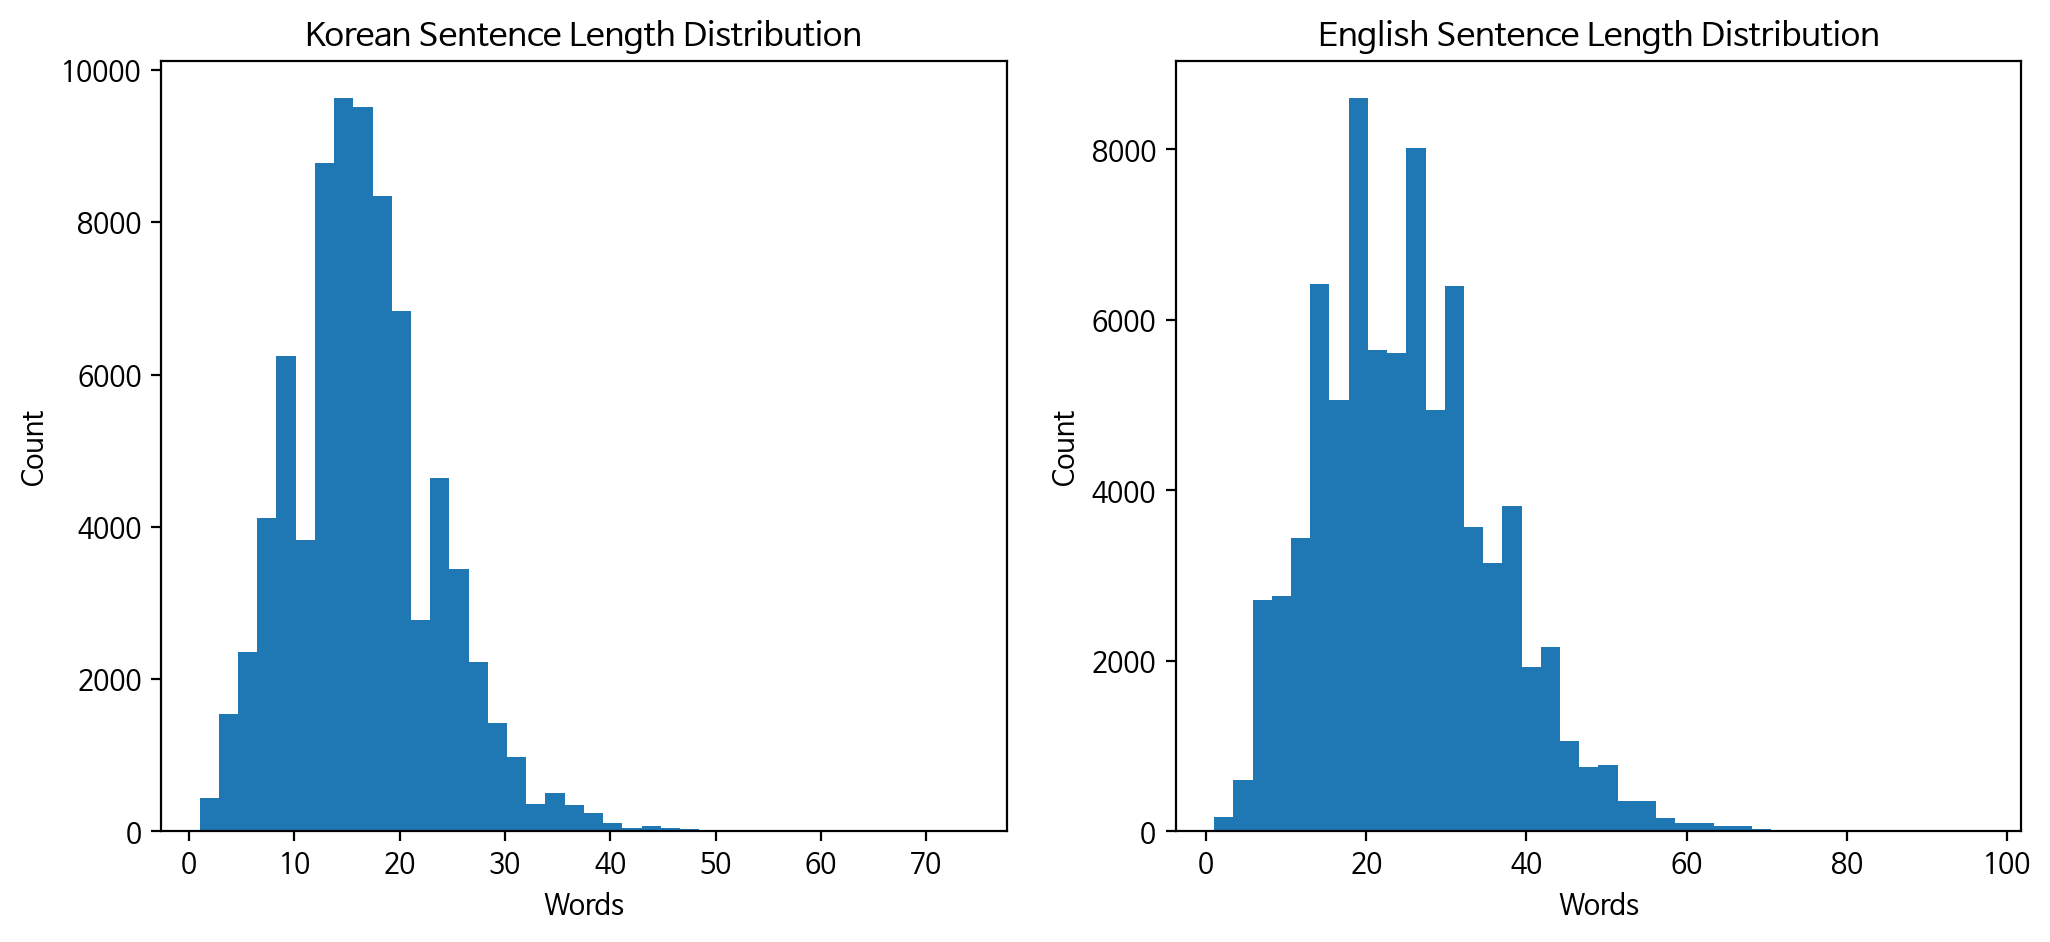

이상치 문장쌍 개수: 638
KOR: 어휘
ENG: the geneva based commission , in its annual study of the industry titled world robotics 2001 , said a record 100 , 000 robots were installed last year , up 25 percent on 1999 . 

KOR: 어휘
ENG: postal service whose postmaster told a senate panel that the financial impact of the anthrax crisis could be several billion dollars uses robots to sort parcels , but other automated equipment sorts letters . 

KOR: 잇따른 토네이도에 의해 36명의 사망자 발생
ENG: emergency workers and stunned residents across the south and great lakes regions picked through shattered homes and buildings after a string of tornadoes left at least 36 people dead and dozens injured . 

KOR: 핵무기 개발 완료를 공식 발표한 북한
ENG: the studio later retracted the statement , saying reports of bootleg copies hadn't been substantiated , but an ap search discovered what appeared to be the movie available on a site hosted in europe . 

KOR: 2월이면 폐기될 미르 우주정거장
ENG: the 14 year old mir space station will be ditched in february in 

In [ ]:
# 데이터 로드
questions, answers = load_data(KOR_TRAIN_PATH, ENG_TRAIN_PATH)

# -------------------------------------------------------------
# 1. 기본 정보 출력
# -------------------------------------------------------------
print("="*50)
print(f"총 문장쌍 개수: {len(questions)}")
print("예시 3개:")
for i in range(3):
    print(f"kor: {questions[i]}")
    print(f"eng: {answers[i]}")
    print()

# -------------------------------------------------------------
# 2. 중복 & 결측치 확인
# -------------------------------------------------------------
print("="*50)

# 중복
pairs = list(zip(questions, answers))
duplicates = len(pairs) - len(set(pairs))

# 결측치/빈 문장
missing = 0
for q, a in pairs:
    if q is None or a is None:
        missing += 1
    elif str(q).strip() == "" or str(a).strip() == "":
        missing += 1

print(f"중복된 문장쌍 개수: {duplicates}")
print(f"결측치 및 빈 문장 개수: {missing}")

# -------------------------------------------------------------
# 3. 문장 길이 계산
# -------------------------------------------------------------
kor_len = [len(str(x).split()) for x in questions]
eng_len = [len(str(x).split()) for x in answers]

def print_stats(name, arr):
    print(f"\n=== {name} 문장 길이 통계 ===")
    print(f"최소: {np.min(arr)}")
    print(f"최대: {np.max(arr)}")
    print(f"평균: {np.mean(arr):.2f}")
    print(f"중앙값: {np.median(arr)}")
    print(f"95% 분위수: {np.percentile(arr, 95)}")
    print(f"99% 분위수: {np.percentile(arr, 99)}")

print_stats("한국어", kor_len)
print_stats("영어", eng_len)

# -------------------------------------------------------------
# 4. 히스토그램
# -------------------------------------------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(kor_len, bins=40)
plt.title("Korean Sentence Length Distribution")
plt.xlabel("Words")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(eng_len, bins=40)
plt.title("English Sentence Length Distribution")
plt.xlabel("Words")
plt.ylabel("Count")

plt.show()

# -------------------------------------------------------------
# 5. 이상치 탐지 및 제거
# -------------------------------------------------------------
ratio = []
for k, e in zip(kor_len, eng_len):
    if k == 0:
        ratio.append(np.nan)
    else:
        ratio.append(e / k)

outliers = [(q, a, r) for q, a, r in zip(questions, answers, ratio)
            if (r is not None and (r > 5 or r < 0.2))]

print("="*50)
print(f"이상치 문장쌍 개수: {len(outliers)}")
for q, a, _ in outliers[:5]:
    print("KOR:", q)
    print("ENG:", a, "\n")

# 이상치 제거
filtered_q = []
filtered_a = []

for q, a, r in zip(questions, answers, ratio):
    if r is not None and 0.2 <= r <= 5:
        filtered_q.append(q)
        filtered_a.append(a)

print(f"제거 후 코퍼스 크기: {len(filtered_q)}")

# -------------------------------------------------------------
# 6. 파일 저장
# -------------------------------------------------------------
with open("./data/kor_corpus.txt", "w", encoding="utf-8") as f:
    for line in filtered_q:
        f.write(line + "\n")

with open("./data/eng_corpus.txt", "w", encoding="utf-8") as f:
    for line in filtered_a:
        f.write(line + "\n")

print("data 폴더에 저장 완료: kor_corpus.txt, eng_corpus.txt")

# -------------------------------------------------------------
# 7. Train/Val/Test split
# -------------------------------------------------------------
# train_q, temp_q, train_a, temp_a = train_test_split(
#     filtered_q, filtered_a, test_size=0.2, random_state=SEED
# )

# val_q, test_q, val_a, test_a = train_test_split(
#     temp_q, temp_a, test_size=0.5, random_state=SEED
# )

# train_q, train_a = back_translation_augment(
#     train_q,
#     train_a,
#     sample_size=3000,
#     batch_size=32
# )

# print("\n" + "=" * 60)
# print("최종 데이터셋 구성:")
# print("=" * 60)
# print(f"Train: {len(train_q):,} (증강됨)")
# print(f"Val  : {len(val_q):,} (원본)")
# print(f"Test : {len(test_q):,} (원본)")
# print("=" * 60)

In [ ]:
# # 증강된 데이터 저장
# def save_list(data, filename):
#     path = f"/home/jovyan/work/AIFFEL_quest_rs/GoingDeeper/GD05/data/{filename}"
#     with open(path, "w", encoding="utf-8") as f:
#         for line in data:
#             f.write(line + "\n")

# save_list(train_q, "train_kor.txt")
# save_list(train_a, "train_eng.txt")
# save_list(val_q, "val_kor.txt")
# save_list(val_a, "val_eng.txt")
# save_list(test_q, "test_kor.txt")
# save_list(test_a, "test_eng.txt")

# print("데이터셋별 분리 저장 완료!")

In [ ]:
# 증강된 데이터 다시 로드

# 데이터 로드 함수 정의
def load_list(filename):
    path = DATA_DIR + "/" + filename
    with open(path, "r", encoding="utf-8") as f:
        # readlines()로 읽고 strip()으로 줄바꿈 문자(\n) 제거
        return [line.strip() for line in f.readlines()]

print("분리 저장된 데이터셋 로드 중...")

# 1. Train 데이터 로드 (증강된 데이터)
train_q = load_list("train_kor.txt")
train_a = load_list("train_eng.txt")

# 2. Validation 데이터 로드 (원본)
val_q = load_list("val_kor.txt")
val_a = load_list("val_eng.txt")

# 3. Test 데이터 로드 (원본)
test_q = load_list("test_kor.txt")
test_a = load_list("test_eng.txt")

# 로드 결과 확인
print("=" * 50)
print("데이터 로드 완료 및 변수 할당 성공!")
print(f"Train : {len(train_q):,} (Kor) / {len(train_a):,} (Eng)")
print(f"Val   : {len(val_q):,} (Kor) / {len(val_a):,} (Eng)")
print(f"Test  : {len(test_q):,} (Kor) / {len(test_a):,} (Eng)")
print("=" * 50)

# 예시 출력 (데이터가 제대로 들어왔는지 확인)
print(f"Train 예시: {train_q[0]} -> {train_a[0]}")

분리 저장된 데이터셋 로드 중...
데이터 로드 완료 및 변수 할당 성공!
Train : 65,625 (Kor) / 65,625 (Eng)
Val   : 7,828 (Kor) / 7,828 (Eng)
Test  : 7,829 (Kor) / 7,829 (Eng)
Train 예시: 포틀랜드의 또 다른 자랑거리는 교통편의다 . -> both sunny and rainy portland are well worth checking out .


### EDA 결과

(1) 중복 & 결측치
데이터는 약 8만 개의 문장 쌍으로 이루어져 있으며, 중복 데이터와 결측치는 없다.

---  
(2) 이상치
한/영 문장의 길이를 기준으로 이상치를 판별한 결과 661 쌍의 이상치가 발견되었고 눈으로 봐도 잘못된 번역인 것을 알 수 있으므로, 661개의 이상치는 노이즈로 간주하고 제거했다.  

---
(3) 문장 길이
임시로 공백 기준 토큰화를 한 다음 단어 개수 기준으로 문장 길이를 측정했을 때, 한국어와 영어 모두 최대값과 99% 분위수 사이에 큰 차이가 존재하는 것을 발견했다.  
따라서 SentencePiece 토큰화를 수행한 후, 모델 학습 효율을 위해 극단치는 제거하겠다.

---
(4) 허깅페이스 모델을 이용한 back translation으로 3000개의 문장쌍(new_kor + original_eng)을 추가로 생성했다.

## Section 10. 토크나이저 학습/로드
SentencePiece 토크나이저를 학습하거나 기존 모델을 로드

In [ ]:
# 토크나이저 학습 (또는 로드)
kor_model_path = f"{KOR_TOKENIZER_PREFIX}.model"
eng_model_path = f"{ENG_TOKENIZER_PREFIX}.model"

if os.path.exists(kor_model_path) and os.path.exists(eng_model_path):
    print("기존 토크나이저 로드 중...")
    vocab_src = SentencePieceVocab(kor_model_path)
    vocab_trg = SentencePieceVocab(eng_model_path)
    print(f"한국어 Vocab: {len(vocab_trg):,} tokens")
    print(f"영어 Vocab: {len(vocab_src):,} tokens")
else:
    print("토크나이저 학습 중...")

    # 전체 데이터로 학습 (train + val + test)
    all_kor = train_q + val_q + test_q
    all_eng = train_a + val_a + test_a

    # 한국어 토크나이저 학습
    train_sentencepiece(all_kor, KOR_TOKENIZER_PREFIX, DATA_CONFIG.vocab_size_kor)
    vocab_src = SentencePieceVocab(kor_model_path)

    # 영어 토크나이저 학습
    train_sentencepiece(all_eng, ENG_TOKENIZER_PREFIX, DATA_CONFIG.vocab_size_eng)
    vocab_trg = SentencePieceVocab(eng_model_path)

    print("\n토크나이저 학습 완료!")
    print(f"한국어 Vocab: {len(vocab_src):,} tokens")
    print(f"영어 Vocab: {len(vocab_trg):,} tokens")

토크나이저 학습 중...
SentencePiece 학습: ./tokenizers/sp_kor (Vocab: 16000)
완료: ./tokenizers/sp_kor.model
SentencePiece 학습: ./tokenizers/sp_eng (Vocab: 16000)
완료: ./tokenizers/sp_eng.model

토크나이저 학습 완료!
한국어 Vocab: 16,000 tokens
영어 Vocab: 16,000 tokens


In [ ]:
# SentencePiece 모델 로드
encoder_tokenizer = spm.SentencePieceProcessor()
encoder_tokenizer.load(KOR_TOKENIZER_PREFIX + ".model")

decoder_tokenizer = spm.SentencePieceProcessor()
decoder_tokenizer.load(ENG_TOKENIZER_PREFIX + ".model")

# 샘플로 인코딩, 디코딩 확인
kor_sample = train_q[5000]
eng_sample = train_a[5000]
print("Korean sample:", kor_sample)
print("English sample:", eng_sample)

# 인코딩 + BOS, EOS 토큰 추가
kor_ids = [encoder_tokenizer.bos_id()] + encoder_tokenizer.encode_as_ids(kor_sample) + [encoder_tokenizer.eos_id()]
eng_ids = [decoder_tokenizer.bos_id()] + decoder_tokenizer.encode_as_ids(eng_sample) + [decoder_tokenizer.eos_id()]

print("Korean token IDs (BOS/EOS 포함):", kor_ids)
print("English token IDs (BOS/EOS 포함):", eng_ids)

# 디코딩 (BOS/EOS 포함 토큰도 복원 가능)
kor_decoding = encoder_tokenizer.decode(kor_ids)
eng_decoding = decoder_tokenizer.decode(eng_ids)

print("디코딩 - Korean:", kor_decoding)
print("디코딩 - English:", eng_decoding)

Korean sample: 미국 버클리 소재 캘리포니아 주립대학 연구진은 인도네시아 해안에 서식하는 야생 문어가 매력적인 상대에 대해 소심하거나 로맨틱하지 않은 독선적인 행동은 절대로 하지 않는다는 사실을 밝혀냈다 .
English sample: the study by researchers from the university of california , berkeley , who journeyed off the coast of indonesia found that wild octopuses are far from the shy , unromantic loners their captive brethren appear to be .
Korean token IDs (BOS/EOS 포함): [2, 52, 11009, 1970, 1012, 6425, 3043, 2702, 9, 1356, 7318, 6933, 7, 3374, 11108, 12, 5531, 114, 1830, 11, 67, 649, 896, 262, 197, 58, 9149, 108, 420, 3234, 276, 114, 711, 9, 3991, 17, 557, 586, 7, 272, 6, 7502, 4, 3]
English token IDs (BOS/EOS 포함): [2, 4, 654, 32, 1260, 30, 4, 398, 11, 577, 6, 7109, 6, 46, 2935, 9, 157, 4, 689, 11, 1597, 205, 19, 2098, 11231, 108, 40, 493, 30, 4, 2391, 29, 6, 173, 1365, 628, 3247, 2002, 97, 7, 53, 7026, 12210, 14725, 407, 10, 24, 5, 3]
디코딩 - Korean: 미국 버클리 소재 캘리포니아 주립대학 연구진은 인도네시아 해안에 서식하는 야생 문어가 매력적인 상대에 대해 소심하거나 로맨틱하지 않은 독선적인 행동은 절대로 하지 않는다는 사실을 밝혀냈다 .
디코딩 - English: th

한국어 최대 길이: 140
영어 최대 길이: 114
한국어 평균 길이: 27.19
영어 평균 길이: 29.12
------------------------------
상위 90% 길이 -> 한국어: 42 | 영어: 46
상위 95% 길이 -> 한국어: 48 | 영어: 52
상위 99% 길이 -> 한국어: 60 | 영어: 64
상위 99.9% 길이 -> 한국어: 80 | 영어: 80


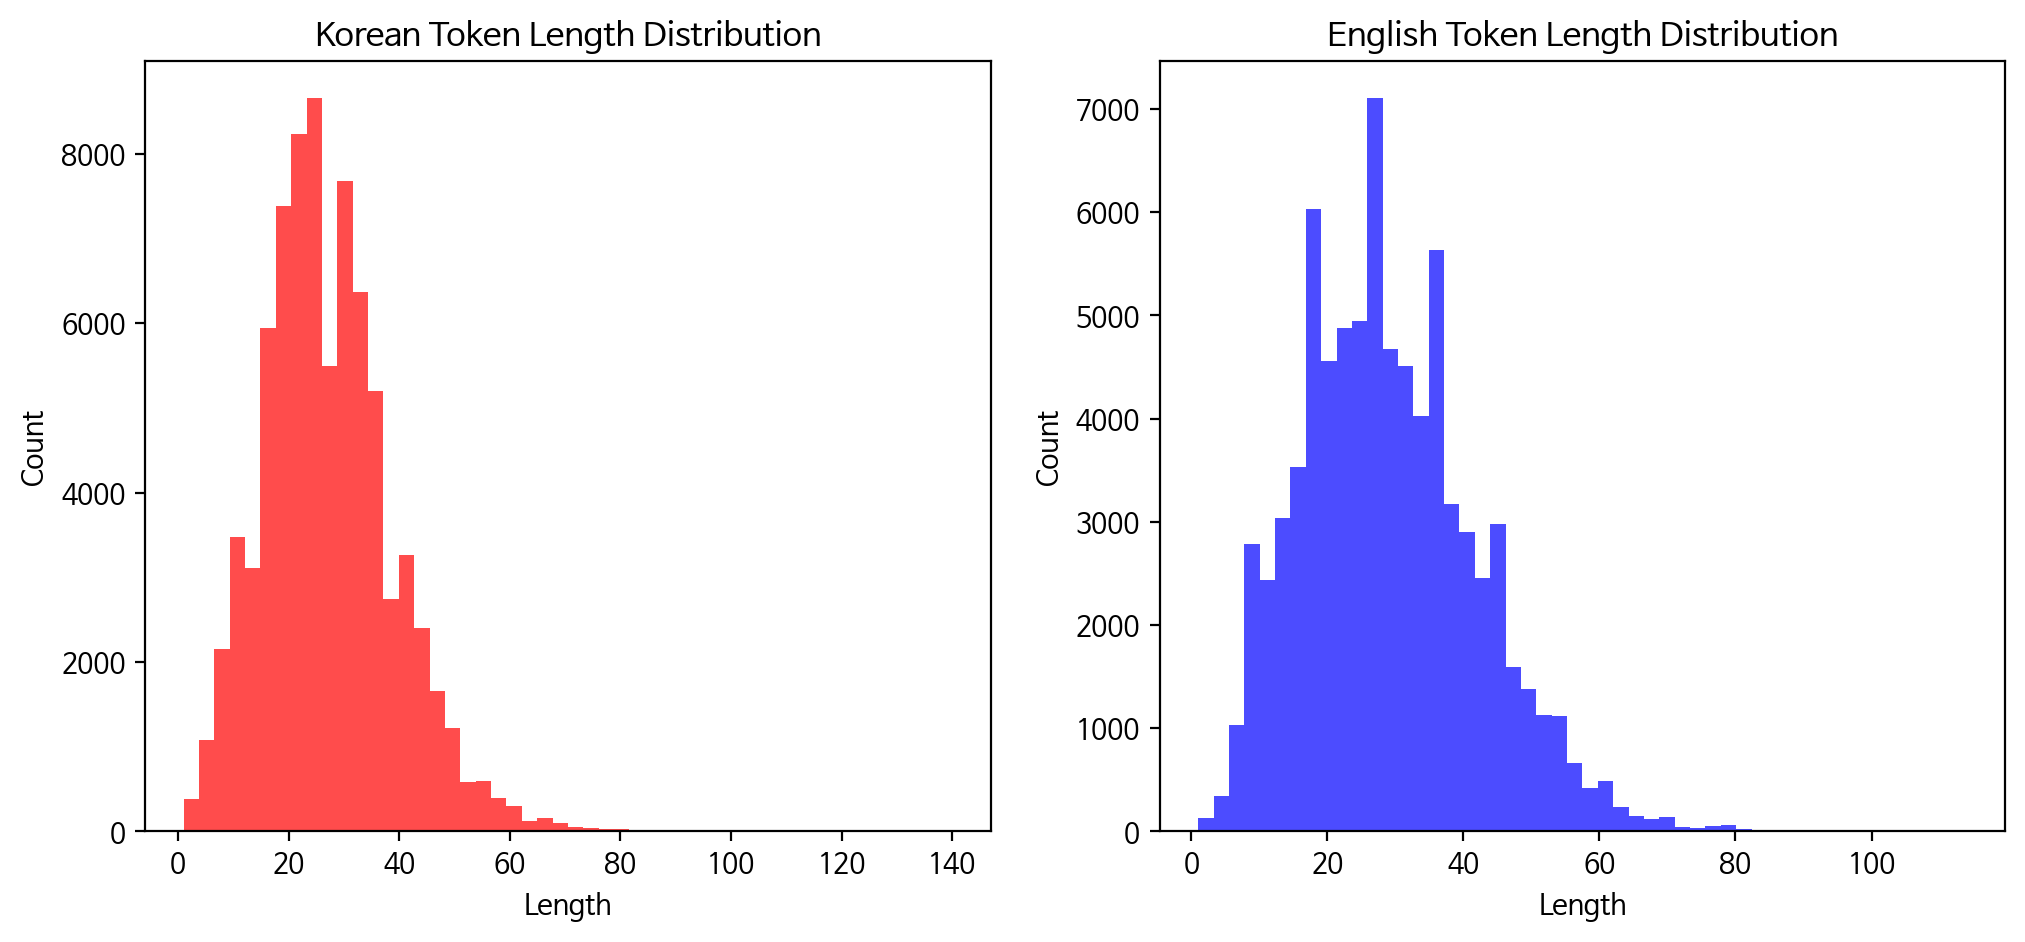

In [ ]:
# 토큰화 후 길이 분석
kor_proc = [preprocess_sentence(x) for x in questions]
eng_proc = [preprocess_sentence(x) for x in answers]

kor_ids = [encoder_tokenizer.encode_as_ids(x) for x in kor_proc]
eng_ids = [decoder_tokenizer.encode_as_ids(x) for x in eng_proc]

kor_len_ids = [len(x) for x in kor_ids]
eng_len_ids = [len(x) for x in eng_ids]

print(f"한국어 최대 길이: {max(kor_len_ids)}")
print(f"영어 최대 길이: {max(eng_len_ids)}")
print(f"한국어 평균 길이: {np.mean(kor_len_ids):.2f}")
print(f"영어 평균 길이: {np.mean(eng_len_ids):.2f}")

print("-" * 30)
for per in [90, 95, 99, 99.9]:
    print(
        f"상위 {per}% 길이 -> 한국어: {int(np.percentile(kor_len_ids, per))} | "
        f"영어: {int(np.percentile(eng_len_ids, per))}"
    )

# 토큰 길이 분포 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(kor_len_ids, bins=50, alpha=0.7, color='red')
plt.title('Korean Token Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(eng_len_ids, bins=50, alpha=0.7, color='blue')
plt.title('English Token Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')

plt.show()

max_length = 70 정도만 해도 빈도 수 상위 99%의 단어는 커버할 수 있다.  
따라서 최대 길이는 70으로 지정한다.

## Section 11. DataLoader 생성

In [ ]:
print("=" * 60)
print("DataLoader 생성")

# Dataset 생성
train_dataset = TranslationDataset(train_q, train_a, vocab_src, vocab_trg, DATA_CONFIG.max_length)
val_dataset = TranslationDataset(val_q, val_a, vocab_src, vocab_trg, DATA_CONFIG.max_length)
test_dataset = TranslationDataset(test_q, test_a, vocab_src, vocab_trg, DATA_CONFIG.max_length)

# DataLoader 생성
collate_with_pad = lambda batch: collate_fn(batch, pad_idx=vocab_src.PAD_ID)

train_loader = DataLoader(
    train_dataset,
    batch_size=DATA_CONFIG.batch_size,
    shuffle=True,
    collate_fn=collate_with_pad,
    num_workers=DATA_CONFIG.num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=DATA_CONFIG.batch_size,
    shuffle=False,
    collate_fn=collate_with_pad,
    num_workers=DATA_CONFIG.num_workers
)

test_loader = DataLoader(
    test_dataset,
    batch_size=DATA_CONFIG.batch_size,
    shuffle=False,
    collate_fn=collate_with_pad,
    num_workers=DATA_CONFIG.num_workers
)

print(f"  Train Batches: {len(train_loader)}")
print(f"  Val Batches:   {len(val_loader)}")
print(f"  Test Batches:  {len(test_loader)}")
print("DataLoader 생성 완료!")

DataLoader 생성
  Train Batches: 513
  Val Batches:   62
  Test Batches:  62
DataLoader 생성 완료!


## Section 12. 모델 초기화
Transformer 모델, 옵티마이저, 손실 함수 초기화

In [ ]:
print("모델 초기화")
# 모델 생성
model = Transformer(vocab_src, vocab_trg, MODEL_CONFIG).to(device)

print(f"모델 파라미터 수: {model.count_parameters():,}")
print(f"디바이스: {device}")

# 옵티마이저
optimizer = optim.AdamW(
    model.parameters(),
    lr=TRAIN_CONFIG.learning_rate,
    betas=TRAIN_CONFIG.betas,
    eps=TRAIN_CONFIG.eps,
    weight_decay=TRAIN_CONFIG.weight_decay
)

# 스케줄러
scheduler = get_noam_scheduler(
    optimizer,
    d_model=MODEL_CONFIG.emb_dim,
    warmup_steps=4000
)

# 손실 함수
criterion = nn.CrossEntropyLoss(
    ignore_index=vocab_trg.PAD_ID,
    label_smoothing=TRAIN_CONFIG.label_smoothing
).to(device)

모델 초기화
모델 파라미터 수: 23,345,792
디바이스: cuda


## Section 13. 모델 학습

In [ ]:
# best_valid_loss = float('inf')
# patience_counter = 0
# train_losses = []
# val_losses = []

# for epoch in tqdm(range(TRAIN_CONFIG.num_epochs), desc="Total Epochs"):
#     start_time = time.time()

#     # 학습
#     train_loss = train_epoch(model, train_loader, optimizer, criterion, TRAIN_CONFIG.clip, device)

#     # 검증
#     val_loss = evaluate(model, val_loader, criterion, device)

#     # 시간 측정
#     end_time = time.time()
#     epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

#     # 손실 기록
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)

#     # 모델 저장 및 조기 종료
#     save_msg = ""
#     if val_loss < best_valid_loss - TRAIN_CONFIG.min_delta:
#         best_valid_loss = val_loss
#         patience_counter = 0
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_loss': train_loss,
#             'val_loss': val_loss,
#         }, MODEL_SAVE_PATH)
#         save_msg = "Model Saved"
#     else:
#         patience_counter += 1
#         if patience_counter >= TRAIN_CONFIG.patience:
#             tqdm.write(f"\early stopping at: {TRAIN_CONFIG.patience} epoch w/o improvement ")
#             break

#     # 로그 출력
#     log_msg = (
#         f'[Epoch {epoch+1:02d}] '
#         f'Train Loss: {train_loss:.4f} | '
#         f'Val Loss: {val_loss:.4f} | '
#         f'PPL: {np.exp(train_loss):.2f} | '
#         f'Time: {int(epoch_mins)}m {int(epoch_secs)}s'
#         f'{save_msg}'
#     )
#     tqdm.write(log_msg)

# print("=" * 60)
# print("학습 완료")
# print(f"Best Val Loss: {best_valid_loss:.4f}")
# print("=" * 60)

In [ ]:
# ==========================================
# Mixed Precision 설정을 위한 Scaler 초기화
# ==========================================
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

best_valid_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

print(f"학습 시작 (Mixed Precision: {'On' if TRAIN_CONFIG.amp == True else 'Off'})")

for epoch in tqdm(range(TRAIN_CONFIG.num_epochs), desc="Total Epochs"):
    start_time = time.time()

    # ==========================================
    # scaler 인자 전달
    # ==========================================
    train_loss = train_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
        TRAIN_CONFIG.clip,
        device,
        scaler,
        scheduler=scheduler
    )

    # 검증
    val_loss = evaluate_step(model, val_loader, criterion, device)

    # 시간 측정
    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    # 손실 기록
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # 모델 저장 및 조기 종료 로직
    save_msg = ""
    if val_loss < best_valid_loss - TRAIN_CONFIG.min_delta:
        best_valid_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler_state_dict': scaler.state_dict(), # Scaler 상태도 저장 권장
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, MODEL_SAVE_PATH)
        save_msg = "Model Saved"
    else:
        patience_counter += 1
        if patience_counter >= TRAIN_CONFIG.patience:
            tqdm.write(f"\nEarly stopping at: {epoch+1} epoch")
            break

    # 로그 출력
    log_msg = (
        f'[Epoch {epoch+1:02d}] '
        f'Train Loss: {train_loss:.4f} | '
        f'Val Loss: {val_loss:.4f} | '
        f'PPL: {np.exp(train_loss):.2f} | '
        f'Time: {int(epoch_mins)}m {int(epoch_secs)}s '
        f'{save_msg}'
    )
    tqdm.write(log_msg)

print("=" * 60)
print("학습 완료")
print(f"Best Val Loss: {best_valid_loss:.4f}")
print("=" * 60)

학습 시작 (Mixed Precision: On)


Total Epochs:   1%|▏         | 1/70 [01:43<1:58:38, 103.17s/it]

[Epoch 01] Train Loss: 7.7834 | Val Loss: 6.2898 | PPL: 2400.43 | Time: 1m 36s Model Saved


Total Epochs:   3%|▎         | 2/70 [03:18<1:52:01, 98.85s/it] 

[Epoch 02] Train Loss: 5.8883 | Val Loss: 5.4487 | PPL: 360.81 | Time: 1m 34s Model Saved


Total Epochs:   4%|▍         | 3/70 [04:54<1:48:32, 97.20s/it]

[Epoch 03] Train Loss: 5.2300 | Val Loss: 4.9795 | PPL: 186.79 | Time: 1m 34s Model Saved


Total Epochs:   6%|▌         | 4/70 [06:34<1:48:03, 98.23s/it]

[Epoch 04] Train Loss: 4.8482 | Val Loss: 4.6905 | PPL: 127.51 | Time: 1m 33s Model Saved


Total Epochs:   7%|▋         | 5/70 [08:08<1:45:06, 97.03s/it]

[Epoch 05] Train Loss: 4.5585 | Val Loss: 4.4676 | PPL: 95.44 | Time: 1m 33s Model Saved


Total Epochs:   9%|▊         | 6/70 [09:44<1:43:01, 96.59s/it]

[Epoch 06] Train Loss: 4.3201 | Val Loss: 4.2938 | PPL: 75.19 | Time: 1m 34s Model Saved


Total Epochs:  10%|█         | 7/70 [11:19<1:40:46, 95.97s/it]

[Epoch 07] Train Loss: 4.1213 | Val Loss: 4.1662 | PPL: 61.64 | Time: 1m 33s Model Saved


Total Epochs:  11%|█▏        | 8/70 [12:54<1:38:52, 95.68s/it]

[Epoch 08] Train Loss: 3.9583 | Val Loss: 4.0638 | PPL: 52.37 | Time: 1m 34s Model Saved


Total Epochs:  13%|█▎        | 9/70 [14:29<1:37:14, 95.64s/it]

[Epoch 09] Train Loss: 3.7924 | Val Loss: 3.9704 | PPL: 44.36 | Time: 1m 34s Model Saved


Total Epochs:  14%|█▍        | 10/70 [16:05<1:35:32, 95.54s/it]

[Epoch 10] Train Loss: 3.6331 | Val Loss: 3.9079 | PPL: 37.83 | Time: 1m 34s Model Saved


Total Epochs:  16%|█▌        | 11/70 [17:40<1:33:41, 95.28s/it]

[Epoch 11] Train Loss: 3.4970 | Val Loss: 3.8596 | PPL: 33.02 | Time: 1m 33s Model Saved


Total Epochs:  17%|█▋        | 12/70 [19:14<1:31:55, 95.10s/it]

[Epoch 12] Train Loss: 3.3805 | Val Loss: 3.8312 | PPL: 29.39 | Time: 1m 33s Model Saved


Total Epochs:  19%|█▊        | 13/70 [20:49<1:30:10, 94.92s/it]

[Epoch 13] Train Loss: 3.2787 | Val Loss: 3.8052 | PPL: 26.54 | Time: 1m 33s Model Saved


Total Epochs:  20%|██        | 14/70 [22:23<1:28:26, 94.75s/it]

[Epoch 14] Train Loss: 3.1867 | Val Loss: 3.7944 | PPL: 24.21 | Time: 1m 33s Model Saved


Total Epochs:  21%|██▏       | 15/70 [23:57<1:26:33, 94.43s/it]

[Epoch 15] Train Loss: 3.1068 | Val Loss: 3.7995 | PPL: 22.35 | Time: 1m 33s 


Total Epochs:  23%|██▎       | 16/70 [25:37<1:26:32, 96.16s/it]

[Epoch 16] Train Loss: 3.0318 | Val Loss: 3.7808 | PPL: 20.73 | Time: 1m 32s Model Saved


Total Epochs:  24%|██▍       | 17/70 [27:11<1:24:22, 95.52s/it]

[Epoch 17] Train Loss: 2.9668 | Val Loss: 3.7837 | PPL: 19.43 | Time: 1m 34s 


Total Epochs:  26%|██▌       | 18/70 [28:44<1:22:13, 94.87s/it]

[Epoch 18] Train Loss: 2.9023 | Val Loss: 3.7907 | PPL: 18.22 | Time: 1m 33s 


Total Epochs:  27%|██▋       | 19/70 [30:18<1:20:17, 94.46s/it]

[Epoch 19] Train Loss: 2.8458 | Val Loss: 3.7906 | PPL: 17.22 | Time: 1m 33s 


Total Epochs:  29%|██▊       | 20/70 [31:51<1:18:28, 94.17s/it]

[Epoch 20] Train Loss: 2.7923 | Val Loss: 3.8002 | PPL: 16.32 | Time: 1m 33s 


Total Epochs:  30%|███       | 21/70 [33:25<1:16:48, 94.06s/it]

[Epoch 21] Train Loss: 2.7458 | Val Loss: 3.7985 | PPL: 15.58 | Time: 1m 33s 


Total Epochs:  31%|███▏      | 22/70 [34:58<1:15:01, 93.77s/it]

[Epoch 22] Train Loss: 2.6992 | Val Loss: 3.8060 | PPL: 14.87 | Time: 1m 33s 


Total Epochs:  33%|███▎      | 23/70 [36:32<1:13:22, 93.67s/it]

[Epoch 23] Train Loss: 2.6553 | Val Loss: 3.8176 | PPL: 14.23 | Time: 1m 33s 


Total Epochs:  34%|███▍      | 24/70 [38:05<1:11:47, 93.63s/it]

[Epoch 24] Train Loss: 2.6145 | Val Loss: 3.8256 | PPL: 13.66 | Time: 1m 33s 


Total Epochs:  36%|███▌      | 25/70 [39:39<1:10:09, 93.55s/it]

[Epoch 25] Train Loss: 2.5767 | Val Loss: 3.8406 | PPL: 13.15 | Time: 1m 33s 


Total Epochs:  36%|███▌      | 25/70 [41:11<1:14:09, 98.88s/it]


Early stopping at: 26 epoch
학습 완료
Best Val Loss: 3.7808


## Section 14. 학습 곡선 시각화
Perplexity = 평균적으로 몇 개의 선택지 중 하나를 고르는지

- PPL = 1 → 모델이 항상 정답 확률 100%로 예측함

- PPL = 10 → 매 토큰마다 약 10개의 후보 중 하나를 고르는 수준

- PPL = 50 → 매우 어렵게 예측하고 있음

PPL이 낮을수록 성능이 좋음.

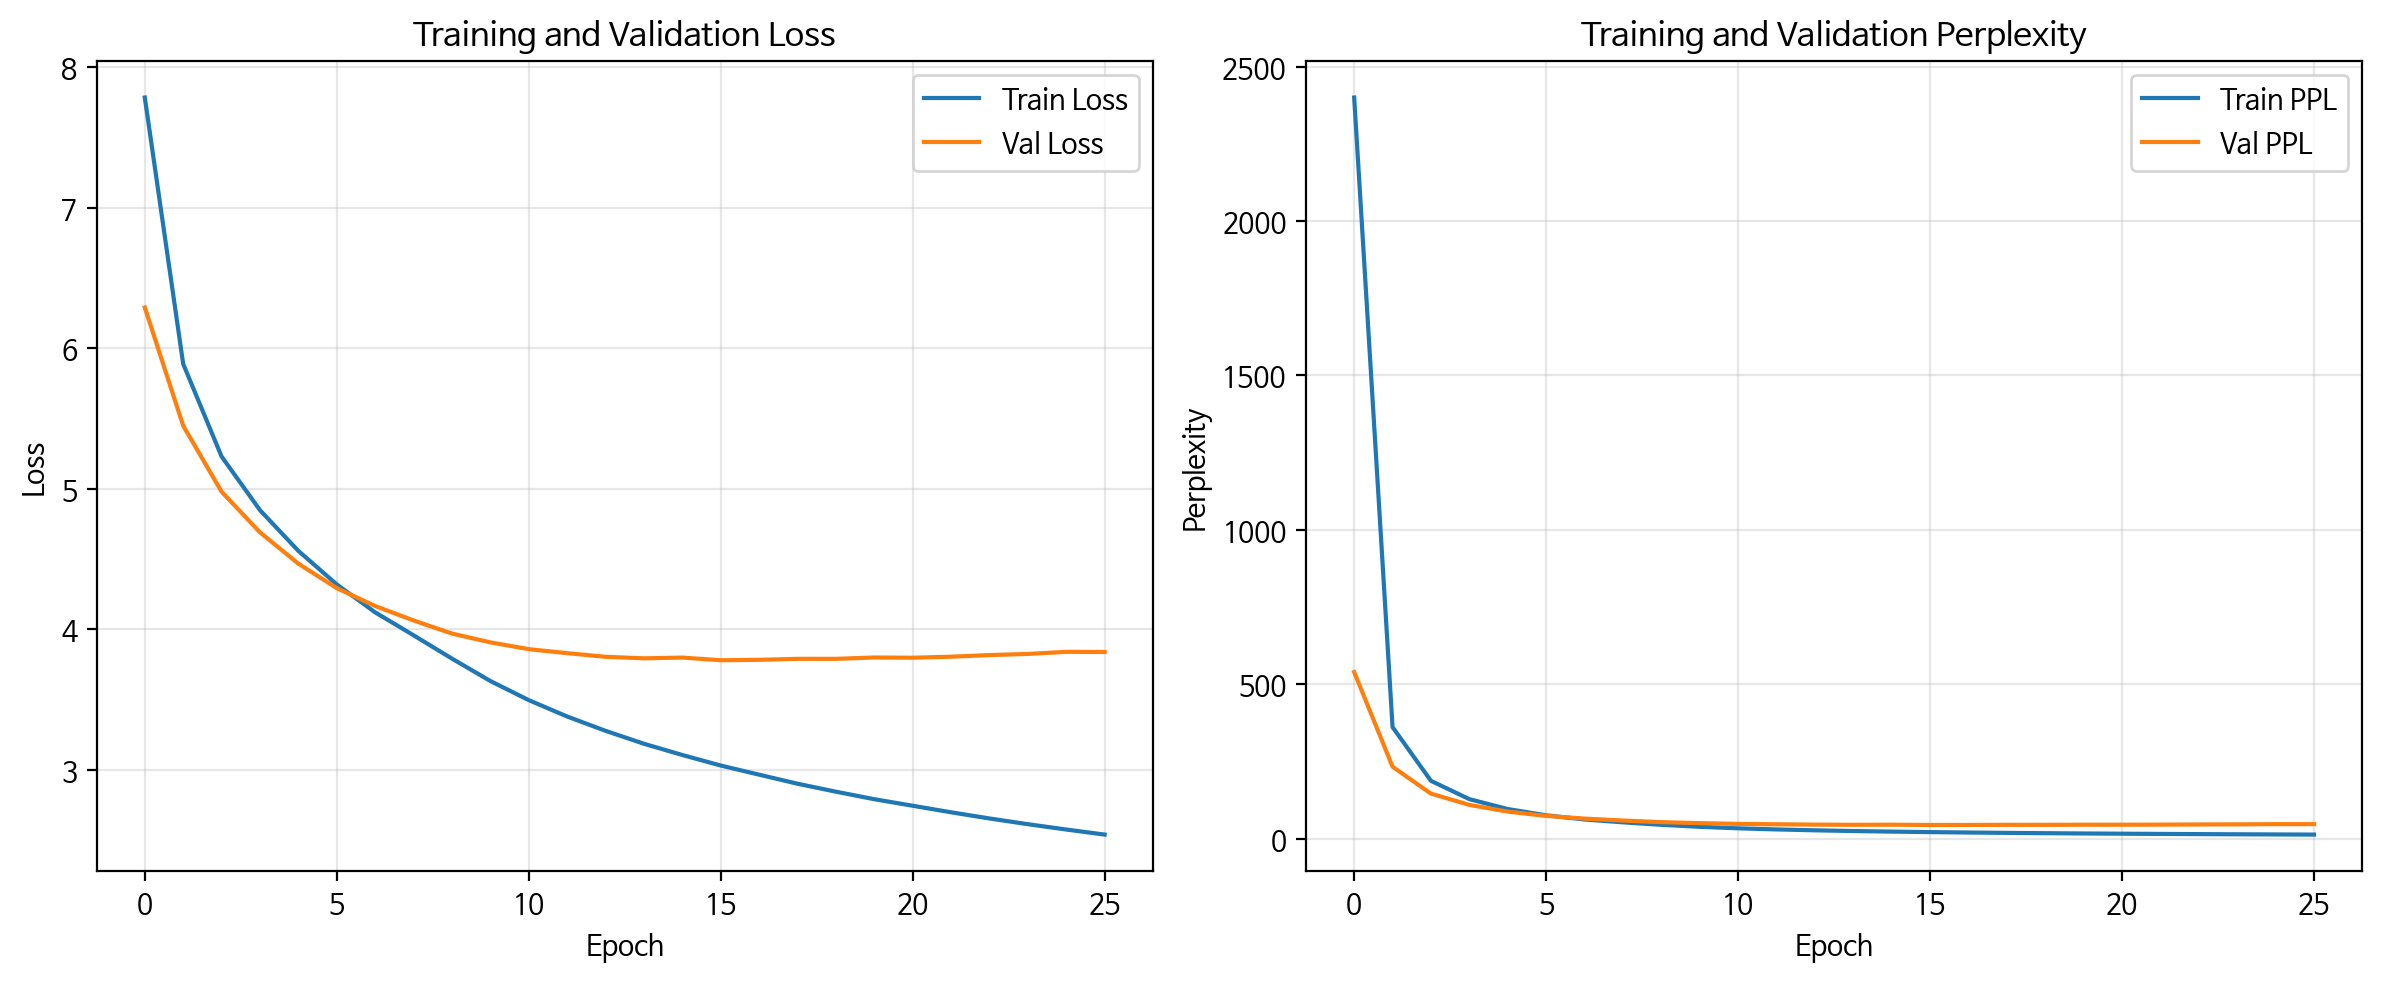

최종 Train Loss: 2.5406
최종 Val Loss: 3.8395
Best Val Loss: 3.7808


In [ ]:
plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Perplexity 그래프
plt.subplot(1, 2, 2)
plt.plot([np.exp(l) for l in train_losses], label='Train PPL')
plt.plot([np.exp(l) for l in val_losses], label='Val PPL')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Training and Validation Perplexity')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"최종 Train Loss: {train_losses[-1]:.4f}")
print(f"최종 Val Loss: {val_losses[-1]:.4f}")
print(f"Best Val Loss: {best_valid_loss:.4f}")

## Section 15: 모델 평가 (Test Set)
테스트 셋에서 모델 성능을 평가

In [ ]:
print("테스트 셋 평가")
# 최고 성능 모델 로드
checkpoint = torch.load(MODEL_SAVE_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

import itertools

# test_loader에서 앞쪽 배치 5개만 가져오기 (약 100~300 문장)
small_iterator = itertools.islice(test_loader, 5)

final_scores = calculate_comprehensive_metrics(
    model,
    small_iterator,  # <-- 전체 test_loader 대신 작은 iterator 전달
    vocab_src,
    vocab_trg,
    device
)

# # 지표 계산 함수 실행 (Test Set 대상)
# final_scores = calculate_comprehensive_metrics(
#     model,
#     test_loader,
#     vocab_src,
#     vocab_trg,
#     device
# )

# 결과 출력
print("Test Set Final Scores:", final_scores)

테스트 셋 평가


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


전체 테스트 데이터에 대해 번역 생성 중...


Generating: 5it [05:24, 64.92s/it]



지표 계산 중... (BERTScore는 시간이 좀 걸립니다)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/20 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/10 [00:00<?, ?it/s]

done in 4095.09 seconds, 0.16 sentences/sec
최종 평가 결과:
  BLEU:      0.0000
  METEOR:    0.0002
  ROUGE-L:   0.0104
  BERTScore: 0.6986
Test Set Final Scores: {'BLEU': 0.0, 'METEOR': np.float64(0.0002039050554480659), 'ROUGE-L': np.float64(0.010358108087839216), 'BERTScore': 0.6986436948180199}


## Section 16: 샘플 번역 테스트
몇 가지 예제 문장을 번역

In [ ]:
# 테스트 문장들
test_sentences = test_q[:3]

model.eval()

for i, sent in enumerate(test_sentences, 1):
    # 전처리
    processed = preprocess_sentence(sent, lang='eng')

    # 번역
    translation, _ = translate_sentence(processed, model, vocab_src, vocab_trg, device)

    # 후처리
    translated_text = "".join([
        t for t in translation
        if t not in ['<eos>', '</s>', '<pad>']
    ]).replace("▁", " ").strip()

    print(f"\n[{i}]")
    print(f"원문: {sent}")
    print(f"번역: {translated_text}")

print("\n" + "=" * 60)


[1]
원문: 직접 선택한 웹사이트 프로그램을 이용했던 참가자들은 연구결과 평균 주당 80분의 운동을 했다 .
번역: upo with had them monday back was themcause fourocause fourcause now with now with now with now with 20 weekal back states them back 20 weekal back 20 weekal back planese back 20 week work back 20 week work military 5 week work militarycause four back 20 week work military about korea if four back 20 week work military about

[2]
원문: 하마스는 또 베이트하눈 , 베이트라히야 , 자발리야 난민캠프 등 파타가 장악하고 있던 가자 지구 북부의 모든 도시와 마을들이 자신들의 손에 넘어갔다고 주장했다 .
번역: attack called 20 4 through where 1 whoonreinginginginginginginginging where country government 4ore planesere planese back planese back 20n planese back 20n planese back 20 stateal how stateal if four called report report national how stateal how stateal if four called an an an an an

[3]
원문: 이라크에서 활동하고 있는 알카에다 1인자인 아부 아유브 알마스리가 이라크 북부 모술에서 검거됐다고 8일 현지시간 국방부 대변인이 밝혔다 .
번역: up 20 called found 20 called national government national governmentcause 20 called national new office time . . . 20 20 20 20

## Section 17: Attention Map

원문 (영어): 트리키는 이 것은 흑인들만의 역사가 아닌 우리 모두의 역사 라며 미국 역사이자 세계의 역사 라고 말했다 .
정답 (한국어): it's not just black history .
예측 (한국어):  called 20 week off 20 week off 20 week off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off off korea off korea also 3 make 20 called korea off korea off

Attention Map:


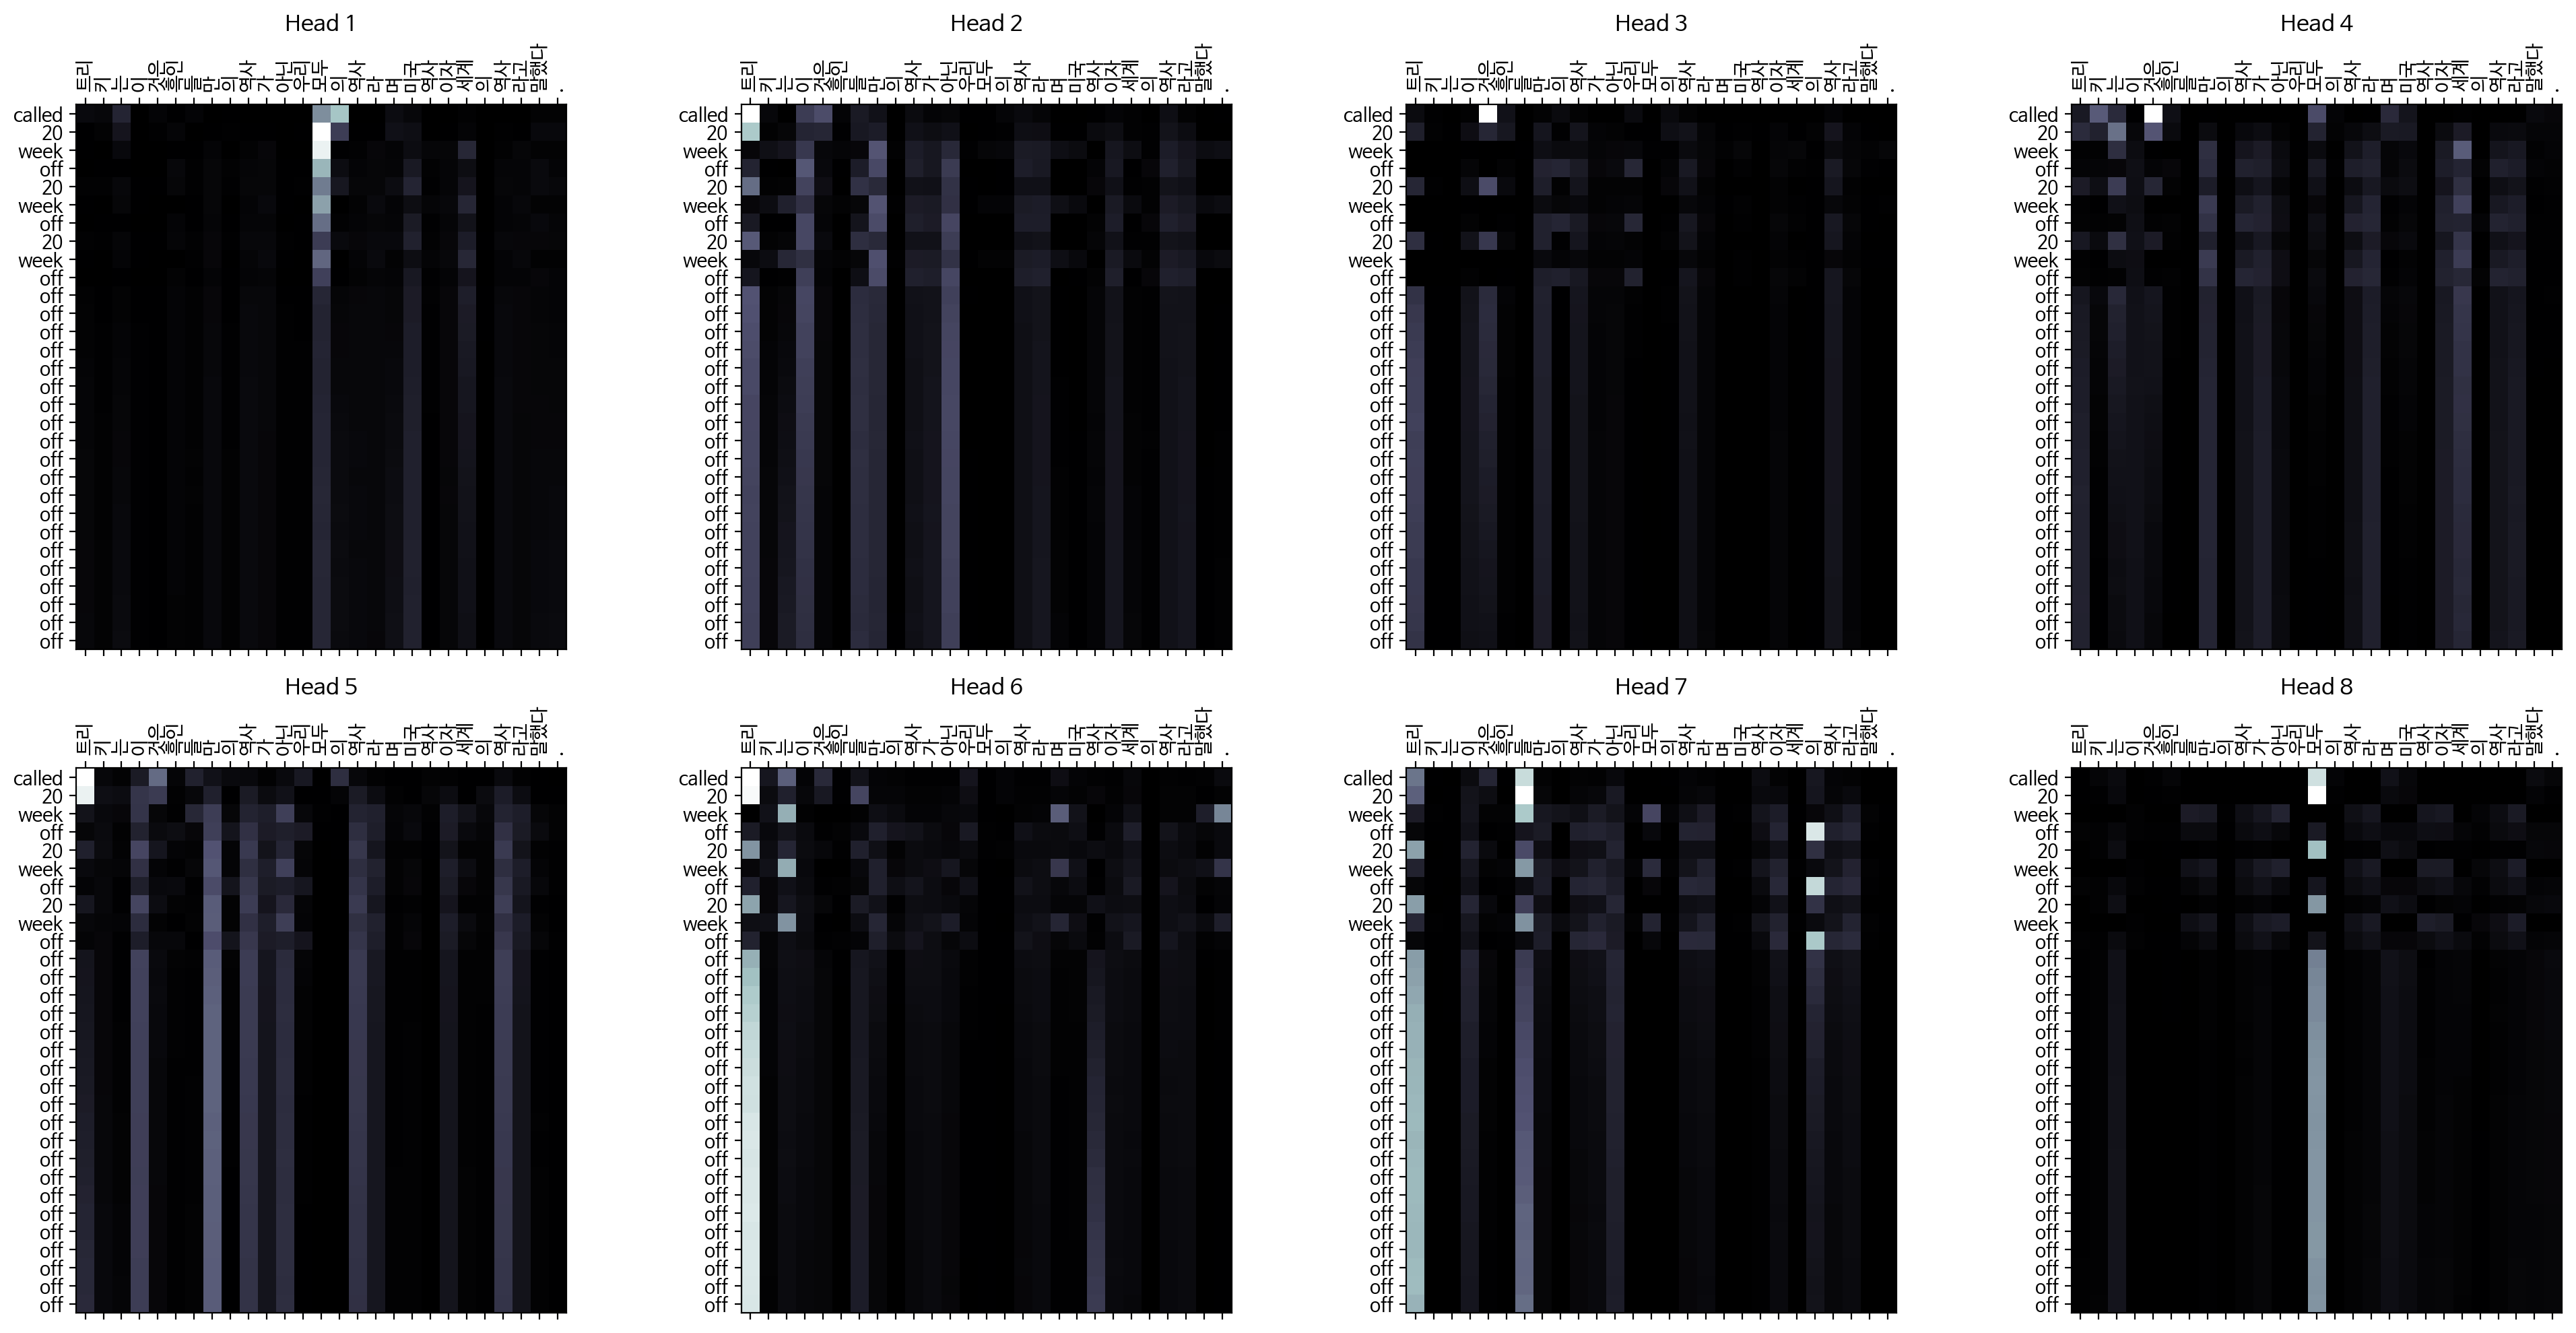

In [ ]:
# 샘플 선택
sample_idx = 5
sample_src = test_dataset.src_list[sample_idx]
sample_trg = test_dataset.trg_list[sample_idx]

print(f"원문 (영어): {sample_src}")
print(f"정답 (한국어): {sample_trg}")

# 번역 및 어텐션 추출
translation, attention = translate_sentence(sample_src, model, vocab_src, vocab_trg, device)

print(f"예측 (한국어): {''.join([t for t in translation if t not in ['<eos>', '</s>']]).replace('▁', ' ')}")
print("\nAttention Map:")

# 소스 토큰화
src_tokens = [vocab_src.itos[i] for i in vocab_src.encode(sample_src)]

# 시각화
display_attention(src_tokens, translation, attention)

## Section 18: 대화형 번역기

직접 문장을 입력해서 번역해볼 수 있습니다.

In [ ]:
def interactive_translate():
    """
    대화형 번역 함수
    """
    print("=" * 60)
    print("대화형 번역기")
    print("=" * 60)
    print("영어 문장을 입력하세요. (종료: 'quit')")
    print("=" * 60)

    model.eval()

    while True:
        user_input = input("\n영어 문장 > ").strip()

        if user_input.lower() in ['quit', 'exit', 'q']:
            print("번역기를 종료합니다.")
            break

        if not user_input:
            continue

        # 전처리
        processed = preprocess_sentence(user_input, lang='eng')

        # 번역
        translation, _ = translate_sentence(processed, model, vocab_src, vocab_trg, device)

        # 후처리
        translated_text = "".join([
            t for t in translation
            if t not in ['<eos>', '</s>', '<pad>']
        ]).replace("▁", " ").strip()

        print(f"번역 결과 > {translated_text}")

## Section 19: 모델 저장 및 로드

나중에 사용하기 위해 모델을 저장하고 로드하는 방법

In [ ]:
# 모델 저장 (이미 학습 중에 저장됨)
print(f"모델 저장 위치: {MODEL_SAVE_PATH}")

# 모델 로드 예시
def load_trained_model(model_path, vocab_src, vocab_trg, config, device):
    """
    학습된 모델을 로드
    """
    # 모델 생성
    model = Transformer(vocab_src, vocab_trg, config).to(device)

    # 체크포인트 로드
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    model.eval()
    return model


# 사용 예시
# loaded_model = load_trained_model(MODEL_SAVE_PATH, vocab_src, vocab_trg, MODEL_CONFIG, device)
# print("모델 로드 완료!")

# Review

Abulation Study

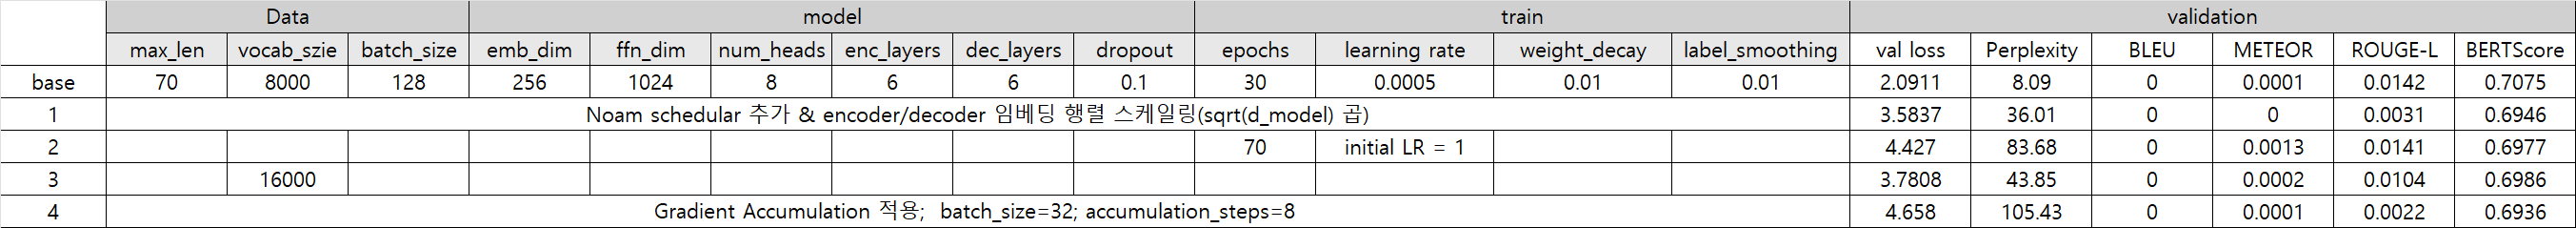  

어려웠던 점
- seq2seq 모델에서는 BLEU가 3.3이라도 나왔었는데, 트랜스포머는 0에서 0.00001이라도 오를 생각을 안 한다.  
- 새로운(정석적인) 코드 구조를 공부하느라 시간을 많이 써서 모델을 학습시킬 시간이 많이 부족했다.  
- 분명 논문에 나온대로 임베딩 후 스케일링을 해줬는데 왜 성능이 내려가는 건지 모르겠다.   


배운 점
- 이번에 작성한 코드 구조를 공부하며 실험 파이프라인 구조가 더 명확해졌다.


개선할 점
- Abulation study 시, 한 번에 하나씩만 바꾸기 (시간이 없고 모델 돌리는데 오래걸려서 이번엔 여러개씩 바꿨더니 오히려 더 어지러워졌다)
- pretrained 토크나이저라도 가져오기 (파인튜닝 경험도 필요할 것 같다.)